# Bayesian regression

_Author: Christoph Rahmede_

Now we want to see how we can implement linear regression in a Bayesian way. The setup is very similar, but we are going to obtain posterior probabilities for the model coefficients as well as the standard deviations of the residuals.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1">Load the data</a></span></li><li><span><a href="#Dummify-origin-column" data-toc-modified-id="Dummify-origin-column-2">Dummify origin column</a></span></li><li><span><a href="#Choose-target-and-predictors" data-toc-modified-id="Choose-target-and-predictors-3">Choose target and predictors</a></span></li><li><span><a href="#Regression-on-a-single-variable" data-toc-modified-id="Regression-on-a-single-variable-4">Regression on a single variable</a></span><ul class="toc-item"><li><span><a href="#Scikit-Learn" data-toc-modified-id="Scikit-Learn-4.1">Scikit-Learn</a></span></li><li><span><a href="#Pymc3" data-toc-modified-id="Pymc3-4.2">Pymc3</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4.3">Summary</a></span></li><li><span><a href="#Scikit-Learn-comparison" data-toc-modified-id="Scikit-Learn-comparison-4.4">Scikit-Learn comparison</a></span></li><li><span><a href="#Posterior-predictive-samples" data-toc-modified-id="Posterior-predictive-samples-4.5">Posterior predictive samples</a></span></li><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-4.6">Forest plot</a></span></li><li><span><a href="#Trace-plots" data-toc-modified-id="Trace-plots-4.7">Trace plots</a></span></li></ul></li><li><span><a href="#Regression-with-multiple-predictors" data-toc-modified-id="Regression-with-multiple-predictors-5">Regression with multiple predictors</a></span><ul class="toc-item"><li><span><a href="#Scikit-Learn" data-toc-modified-id="Scikit-Learn-5.1">Scikit-Learn</a></span></li><li><span><a href="#Pymc3" data-toc-modified-id="Pymc3-5.2">Pymc3</a></span></li><li><span><a href="#Model-summary" data-toc-modified-id="Model-summary-5.3">Model summary</a></span></li><li><span><a href="#Scikit-Learn-comparison" data-toc-modified-id="Scikit-Learn-comparison-5.4">Scikit-Learn comparison</a></span></li><li><span><a href="#Posterior-predictive-samples" data-toc-modified-id="Posterior-predictive-samples-5.5">Posterior predictive samples</a></span></li><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-5.6">Forest plot</a></span></li><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-5.7">Trace plot</a></span></li></ul></li><li><span><a href="#GLM-with-formula-syntax" data-toc-modified-id="GLM-with-formula-syntax-6">GLM with formula syntax</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-6.1">Summary</a></span></li><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-6.2">Forest plot</a></span></li></ul></li><li><span><a href="#Regularized-regression" data-toc-modified-id="Regularized-regression-7">Regularized regression</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-7.1">Summary</a></span></li><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-7.2">Forest plot</a></span></li><li><span><a href="#Lasso-regression" data-toc-modified-id="Lasso-regression-7.3">Lasso regression</a></span></li><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-7.4">Forest plot</a></span></li><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-7.5">Trace plot</a></span></li></ul></li><li><span><a href="#Robust-regression" data-toc-modified-id="Robust-regression-8">Robust regression</a></span><ul class="toc-item"><li><span><a href="#Summary" data-toc-modified-id="Summary-8.1">Summary</a></span></li><li><span><a href="#Forest-plot" data-toc-modified-id="Forest-plot-8.2">Forest plot</a></span></li><li><span><a href="#Trace-plot" data-toc-modified-id="Trace-plot-8.3">Trace plot</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import pymc3 as pm
import arviz as az

## Load the data

In [7]:
df = pd.read_csv(
    '/Users/maartenk/Documents/git/DsMasterClass/dataset-collection/auto-mpg/auto-mpg.csv', sep='\s+', header=None)
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower',
              'weight', 'acceleration', 'year', 'origin', 'name']
df.drop(df[df.horsepower == '?'].index, inplace=True)
df['horsepower'] = df.horsepower.astype(float)
df['brand'] = df.name.map(lambda x: x.split(' ')[0]
                          ).replace(
    {'toyouta': 'toyota',
     'maxda': 'mazda',
     'chevroelt': 'chevrolet',
     'vw': 'volkswagen',
     'vokswagen': 'volkswagen',
     'mercedes-benz': 'mercedes'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 10 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
brand           392 non-null object
dtypes: float64(5), int64(3), object(2)
memory usage: 33.7+ KB


In [8]:
df.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0  3504.0          12.0    70   
1  15.0          8         350.0       165.0  3693.0          11.5    70   
2  18.0          8         318.0       150.0  3436.0          11.0    70   
3  16.0          8         304.0       150.0  3433.0          12.0    70   
4  17.0          8         302.0       140.0  3449.0          10.5    70   

   origin                       name      brand  
0       1  chevrolet chevelle malibu  chevrolet  
1       1          buick skylark 320      buick  
2       1         plymouth satellite   plymouth  
3       1              amc rebel sst        amc  
4       1                ford torino       ford

## Dummify origin column

In [9]:
df['american'] = df.origin.map(lambda x: 1 if x == 1 else 0)
df['european'] = df.origin.map(lambda x: 1 if x == 2 else 0)
df['asian'] = df.origin.map(lambda x: 1 if x == 3 else 0)

american_mpg = df.mpg[df.american == 1]
european_mpg = df.mpg[df.european == 1]
asian_mpg = df.mpg[df.asian == 1]

In [10]:
df.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0  3504.0          12.0    70   
1  15.0          8         350.0       165.0  3693.0          11.5    70   
2  18.0          8         318.0       150.0  3436.0          11.0    70   
3  16.0          8         304.0       150.0  3433.0          12.0    70   
4  17.0          8         302.0       140.0  3449.0          10.5    70   

   origin                       name      brand  american  european  asian  
0       1  chevrolet chevelle malibu  chevrolet         1         0      0  
1       1          buick skylark 320      buick         1         0      0  
2       1         plymouth satellite   plymouth         1         0      0  
3       1              amc rebel sst        amc         1         0      0  
4       1                ford torino       ford         1         0      0

## Choose target and predictors

It is important to standardize the variables. Although we just do linear regression, the MCMC sampling will run into trouble if the variables are not scaled.

In [11]:
target = 'mpg'

In [12]:
predictors = [col for col in df.columns if col not in [
    target, 'origin', 'name', 'brand', 'asian']]

In [13]:
predictors

['cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'year',
 'american',
 'european']

In [14]:
from sklearn.preprocessing import StandardScaler
X = df[predictors]
y = df[target]

# Rescaling will allow us to use the same standard deviation for all
# the beta coefficient priors

scaler = StandardScaler()
Xs = scaler.fit_transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Regression on a single variable

### Scikit-Learn

Fit a scikit-learn model for comparison.

In [15]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(Xs[['horsepower']], y)
print(lr.score(Xs[['horsepower']], y))
print(lr.intercept_, lr.coef_[0])

0.6059482578894348
23.445918367346938 -6.06787240338099


### Pymc3

First we set up the model explicitly defining all the variables we want to use. We have to define prior distributions for the residual standard deviation and the coefficients. 

- For the intercept we can use a flat distribution (an uninformative improper prior giving one regardless of the value) to span a wide range. Here we choose a normal distribution centered on the mean of the target variable. With standardized predictors this is the reasonable choice. 
- For the beta coefficient prior, we use a normal distribution centered at zero with a wide enough standard deviation. We do not know the sign nor the size of the coefficient and don't want to be restrictive in that regard.
- For the standard deviation of the residuals, we set a reasonably flat half-Cauchy distribution spanning the positive real line so that all values are possible though lower ones have more weight.
- The likelihood function takes the regression line as mean and the residual standard deviation.

In [16]:
with pm.Model() as model_simple:
    prior_std = 10
    std = pm.HalfCauchy('error_std', beta=10)
    intercept = pm.Normal('intercept', mu=y.mean(), sd=prior_std)
    beta = pm.Normal('beta', mu=0., sd=prior_std, shape=1)
    y_hat = pm.Normal('y_hat',
                      mu=intercept+pm.math.dot(Xs[['horsepower']], beta),
                      sd=std,
                      observed=y.values)

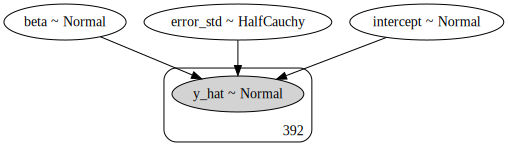

In [17]:
pm.model_to_graphviz(model_simple)

In [18]:
with model_simple:
    trace_simple = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept, error_std]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:05<00:00, 4275.60draws/s]


### Summary

In [19]:
summary = pm.summary(trace_simple)
summary

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
intercept  23.445647  0.247765  0.001301  22.961902  23.927883  32054.063709   
beta__0    -6.064453  0.251976  0.001483  -6.579187  -5.592756  27788.965108   
error_std   4.919638  0.177369  0.001057   4.574688   5.269202  30725.423683   

               Rhat  
intercept  0.999907  
beta__0    1.000035  
error_std  1.000035

### Scikit-Learn comparison

In [20]:
lr.intercept_-summary.loc['intercept', 'mean']

0.00027139285732857843

In [21]:
lr.coef_[0]-summary.loc['beta__0', 'mean']

-0.003418935192994077

### Posterior predictive samples

In [22]:
preds = pm.sample_posterior_predictive(trace_simple, model=model_simple)
pm.r2_score(y.values, preds['y_hat']).r2_mean

100%|██████████| 20000/20000 [00:11<00:00, 1711.99it/s]


0.56

In [23]:
az_data = az.from_pymc3(trace=trace_simple,
                        posterior_predictive=pm.sample_posterior_predictive(trace_simple,
                                                                            samples=300,
                                                                            model=model_simple))

100%|██████████| 300/300 [00:00<00:00, 1610.39it/s]


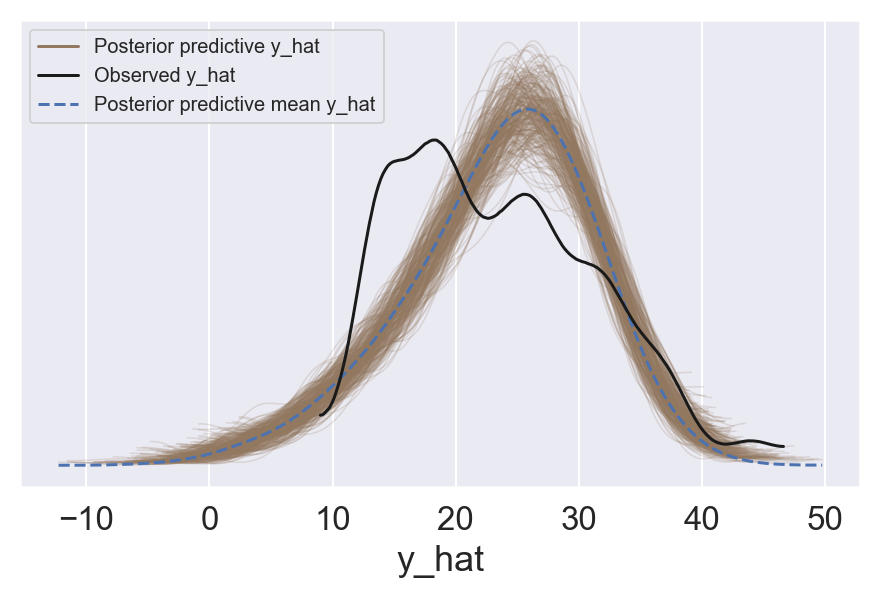

In [31]:
ax = az.plot_ppc(az_data, kind='density')
ax[0].legend(fontsize=10)
plt.show()

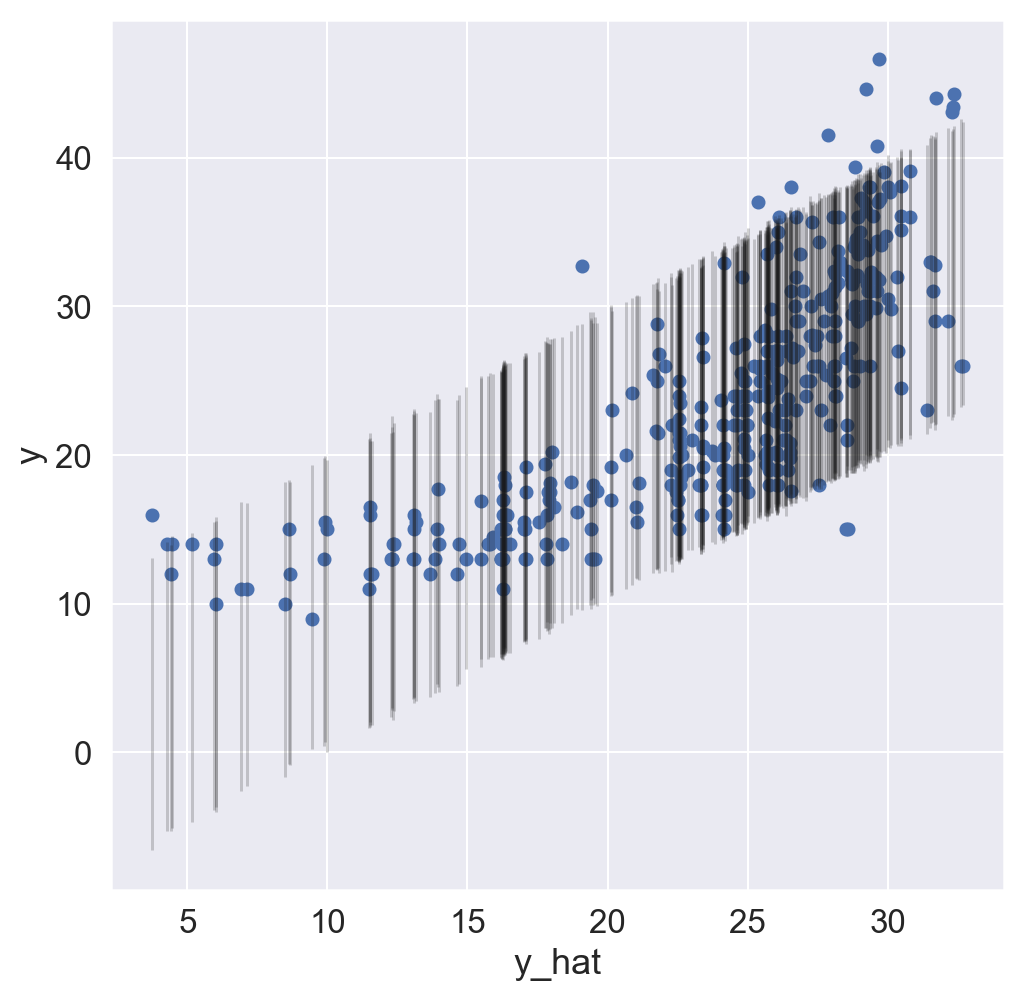

In [21]:
predictions = preds['y_hat'].mean(axis=0)
hpds = np.apply_along_axis(pm.hpd, 0, preds['y_hat']).T

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(predictions, y)
for i in range(len(y)):
    ax.vlines(predictions[i], hpds[i, 0], hpds[i, 1], alpha=0.2)
ax.set_xlabel('y_hat')
ax.set_ylabel('y')
plt.show()

### Forest plot

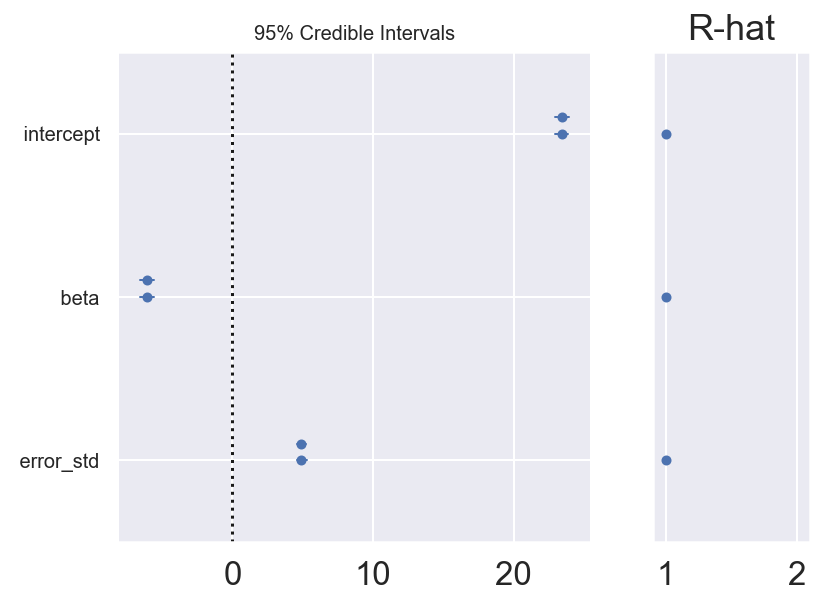

In [22]:
pm.forestplot(trace_simple)
plt.show()

### Trace plots

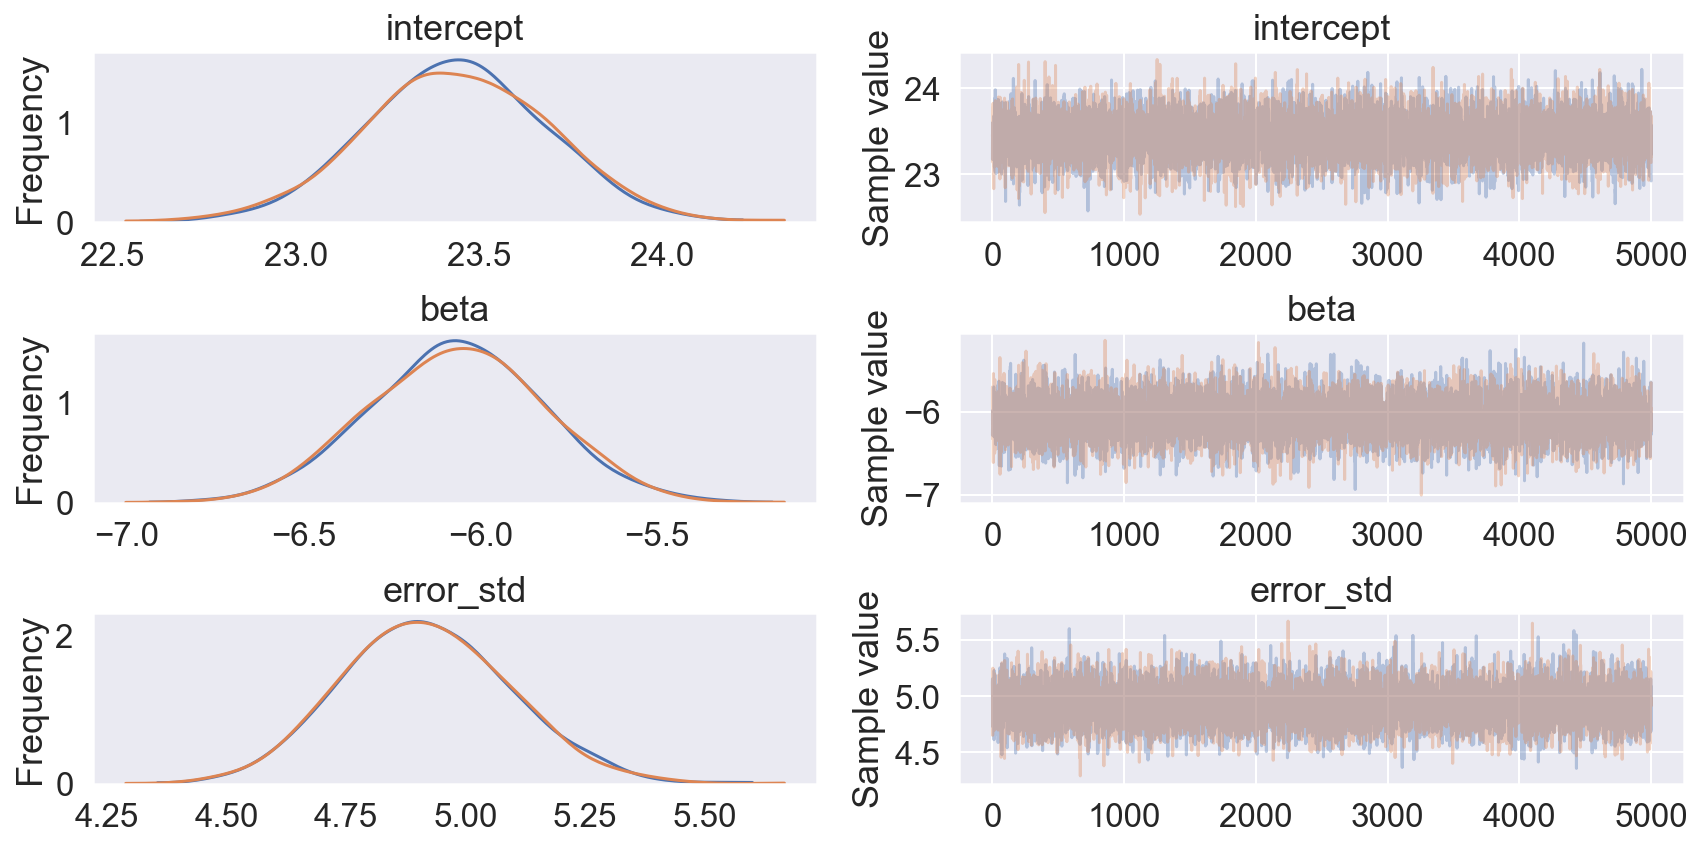

In [23]:
pm.traceplot(trace_simple)
plt.show()

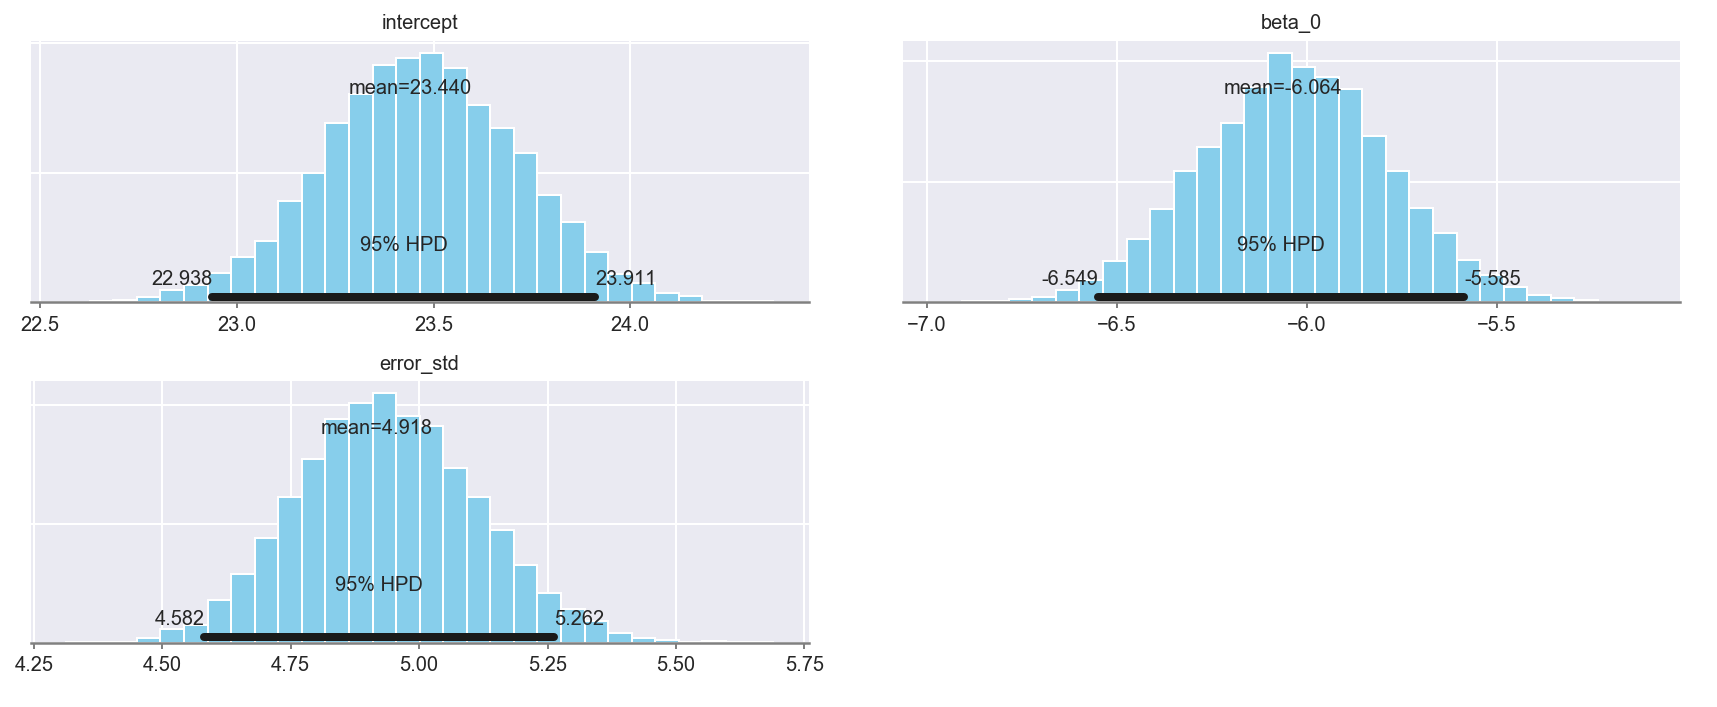

In [24]:
pm.plot_posterior(trace_simple)
plt.show()

## Regression with multiple predictors

Working with multiple predictors is straight-forward. We simply set the `shape` parameter of the beta-priors. Since we standardized all the variables, we can use the same standard deviation for all priors.

### Scikit-Learn

Fit a scikit-learn model for comparison.

In [25]:
lr = LinearRegression()
lr.fit(Xs[predictors], y)
print(lr.score(Xs[predictors], y))
print(lr.intercept_, lr.coef_)

0.8241994699119173
23.44591836734694 [-0.83427197  2.50601874 -0.69900932 -5.69254264  0.21795599  2.85870923
 -1.38131318 -0.08452505]


### Pymc3

In [26]:
with pm.Model() as model:
    prior_std = 10
    std = pm.HalfCauchy('error_std', beta=10)
    intercept = pm.Normal('intercept', mu=y.mean(), sd=prior_std)
    beta = pm.Normal('beta', mu=0., sd=prior_std, shape=len(predictors))
    y_hat = pm.Normal('y_hat',
                      mu=intercept+pm.math.dot(Xs[predictors], beta),
                      sd=std,
                      observed=y.values)

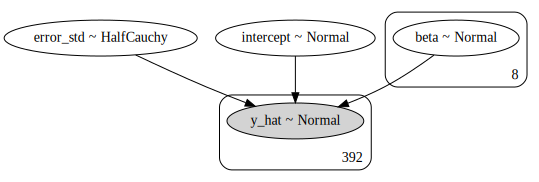

In [27]:
pm.model_to_graphviz(model)

In [28]:
with model:
    trace = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept, error_std]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:23<00:00, 516.93draws/s]
The acceptance probability does not match the target. It is 0.8830091095864097, but should be close to 0.8. Try to increase the number of tuning steps.


### Model summary

In [29]:
summary = pm.summary(trace)
summary

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
intercept  23.448621  0.169271  0.001713  23.123812  23.782851   9724.318815   
beta__0    -0.841126  0.551242  0.007034  -1.911052   0.235529   6438.330456   
beta__1     2.501043  0.791247  0.011257   0.949418   4.058572   5292.831570   
beta__2    -0.705778  0.531241  0.007340  -1.776137   0.312698   6203.774648   
beta__3    -5.679893  0.551292  0.007157  -6.762656  -4.601833   6265.697952   
beta__4     0.213536  0.269332  0.003320  -0.303944   0.756289   6254.359193   
beta__5     2.858549  0.192476  0.001831   2.487650   3.241306  11175.266182   
beta__6    -1.377835  0.269997  0.002960  -1.910375  -0.853780   7450.293932   
beta__7    -0.084250  0.215580  0.002187  -0.491385   0.348122   8595.099441   
error_std   3.314085  0.119213  0.001254   3.087168   3.553283   9586.999821   

               Rhat  
intercept  0.999908  
beta__0    0.999906  
beta__1    0.999906  
beta__2    0.999905  
beta__3    0.999909  
beta__4    0.999903  
beta__5    0.999905  
beta__6    0.999901  
beta__7    0.999905  
error_std  1.000097

### Scikit-Learn comparison

In [30]:
lr.intercept_-summary.loc['intercept', 'mean']

-0.002702419317834881

In [31]:
lr.coef_-pm.summary(trace).loc['beta__0':'beta__7', 'mean'].values

array([ 0.00685436,  0.00497542,  0.00676915, -0.01264925,  0.0044196 ,
        0.00015995, -0.00347808, -0.00027456])

### Posterior predictive samples

In [32]:
from sklearn import metrics
preds = pm.sample_posterior_predictive(trace, model=model)

print(preds['y_hat'].shape)


# averaging over all samples allows to calculate the usual R2 score
metrics.r2_score(y, preds['y_hat'].mean(axis=0))

100%|██████████| 10000/10000 [00:06<00:00, 1615.72it/s]


(10000, 392)


0.8244191479922305

In [33]:
# it is better to use the Bayesian r2 version of pymc3
preds = pm.sample_posterior_predictive(trace, model=model)
pm.r2_score(y.values, preds['y_hat']).r2_mean

100%|██████████| 10000/10000 [00:06<00:00, 1618.72it/s]


0.74

In [34]:
az_data = az.from_pymc3(trace=trace, posterior_predictive=pm.sample_posterior_predictive(
    trace, samples=300, model=model))

100%|██████████| 300/300 [00:00<00:00, 1266.60it/s]


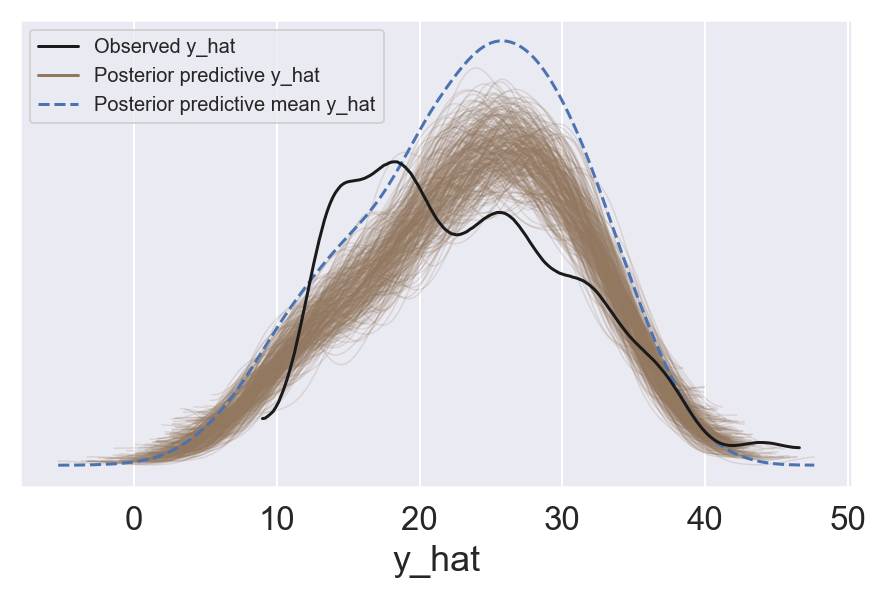

In [35]:
ax = az.plot_ppc(az_data, kind='density')
ax[0].legend(fontsize=10)
plt.show()

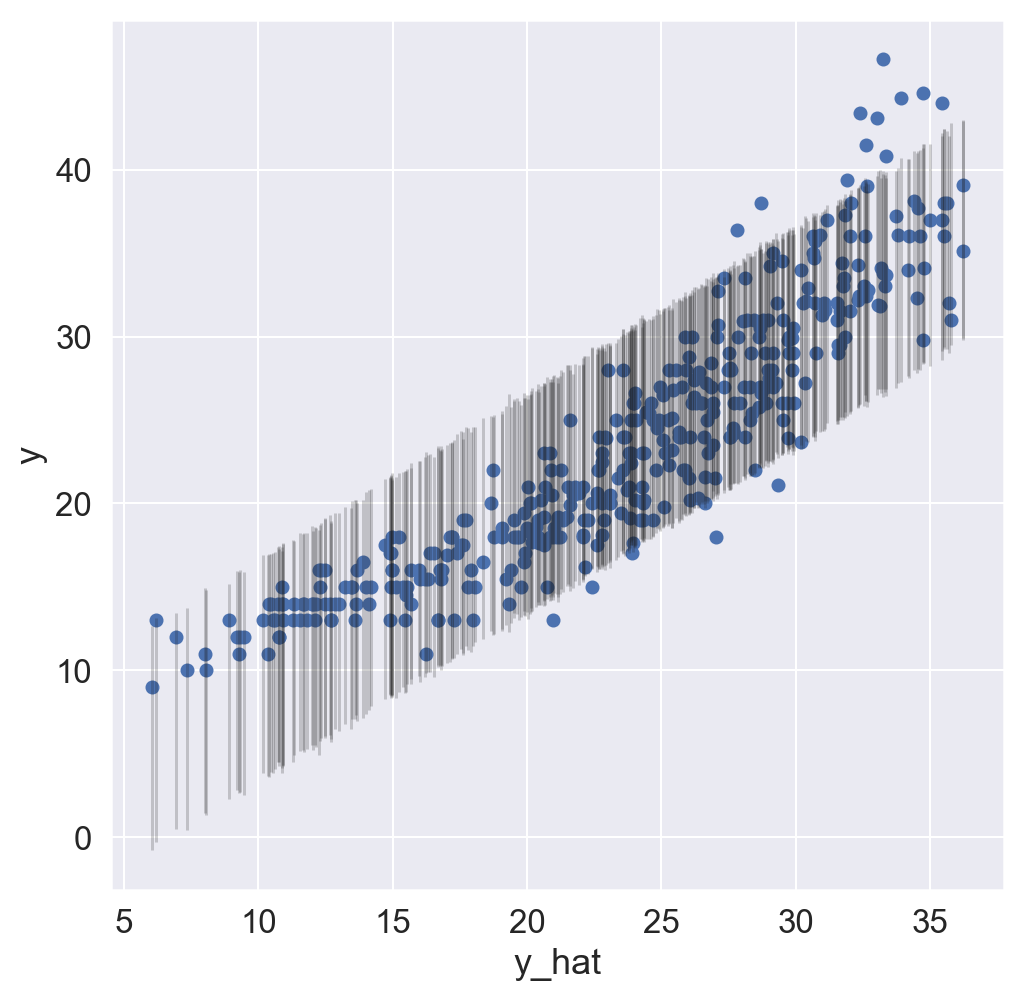

In [36]:
predictions = preds['y_hat'].mean(axis=0)
hpds = np.apply_along_axis(pm.hpd, 0, preds['y_hat']).T

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(predictions, y)
for i in range(len(y)):
    ax.vlines(predictions[i], hpds[i, 0], hpds[i, 1], alpha=0.2)
ax.set_xlabel('y_hat')
ax.set_ylabel('y')
plt.show()

### Forest plot

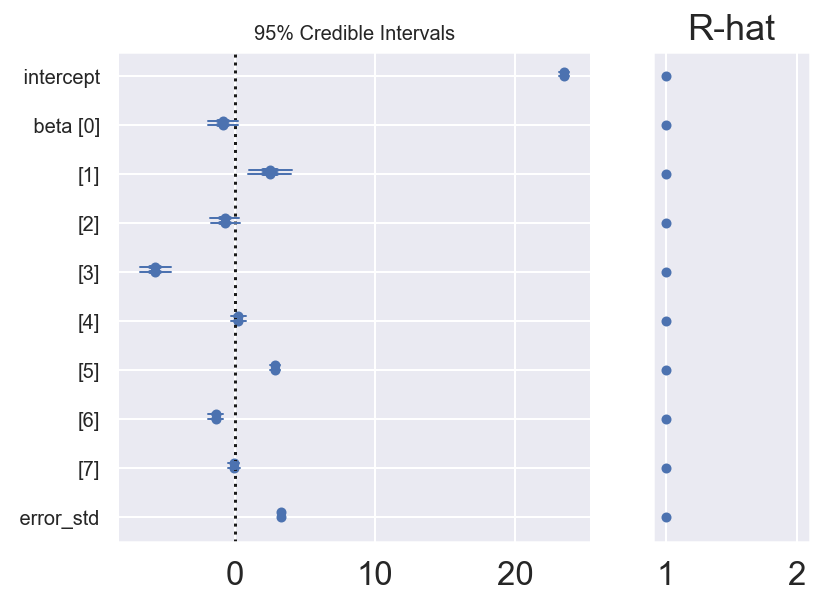

In [37]:
pm.forestplot(trace)
plt.show()

### Trace plot

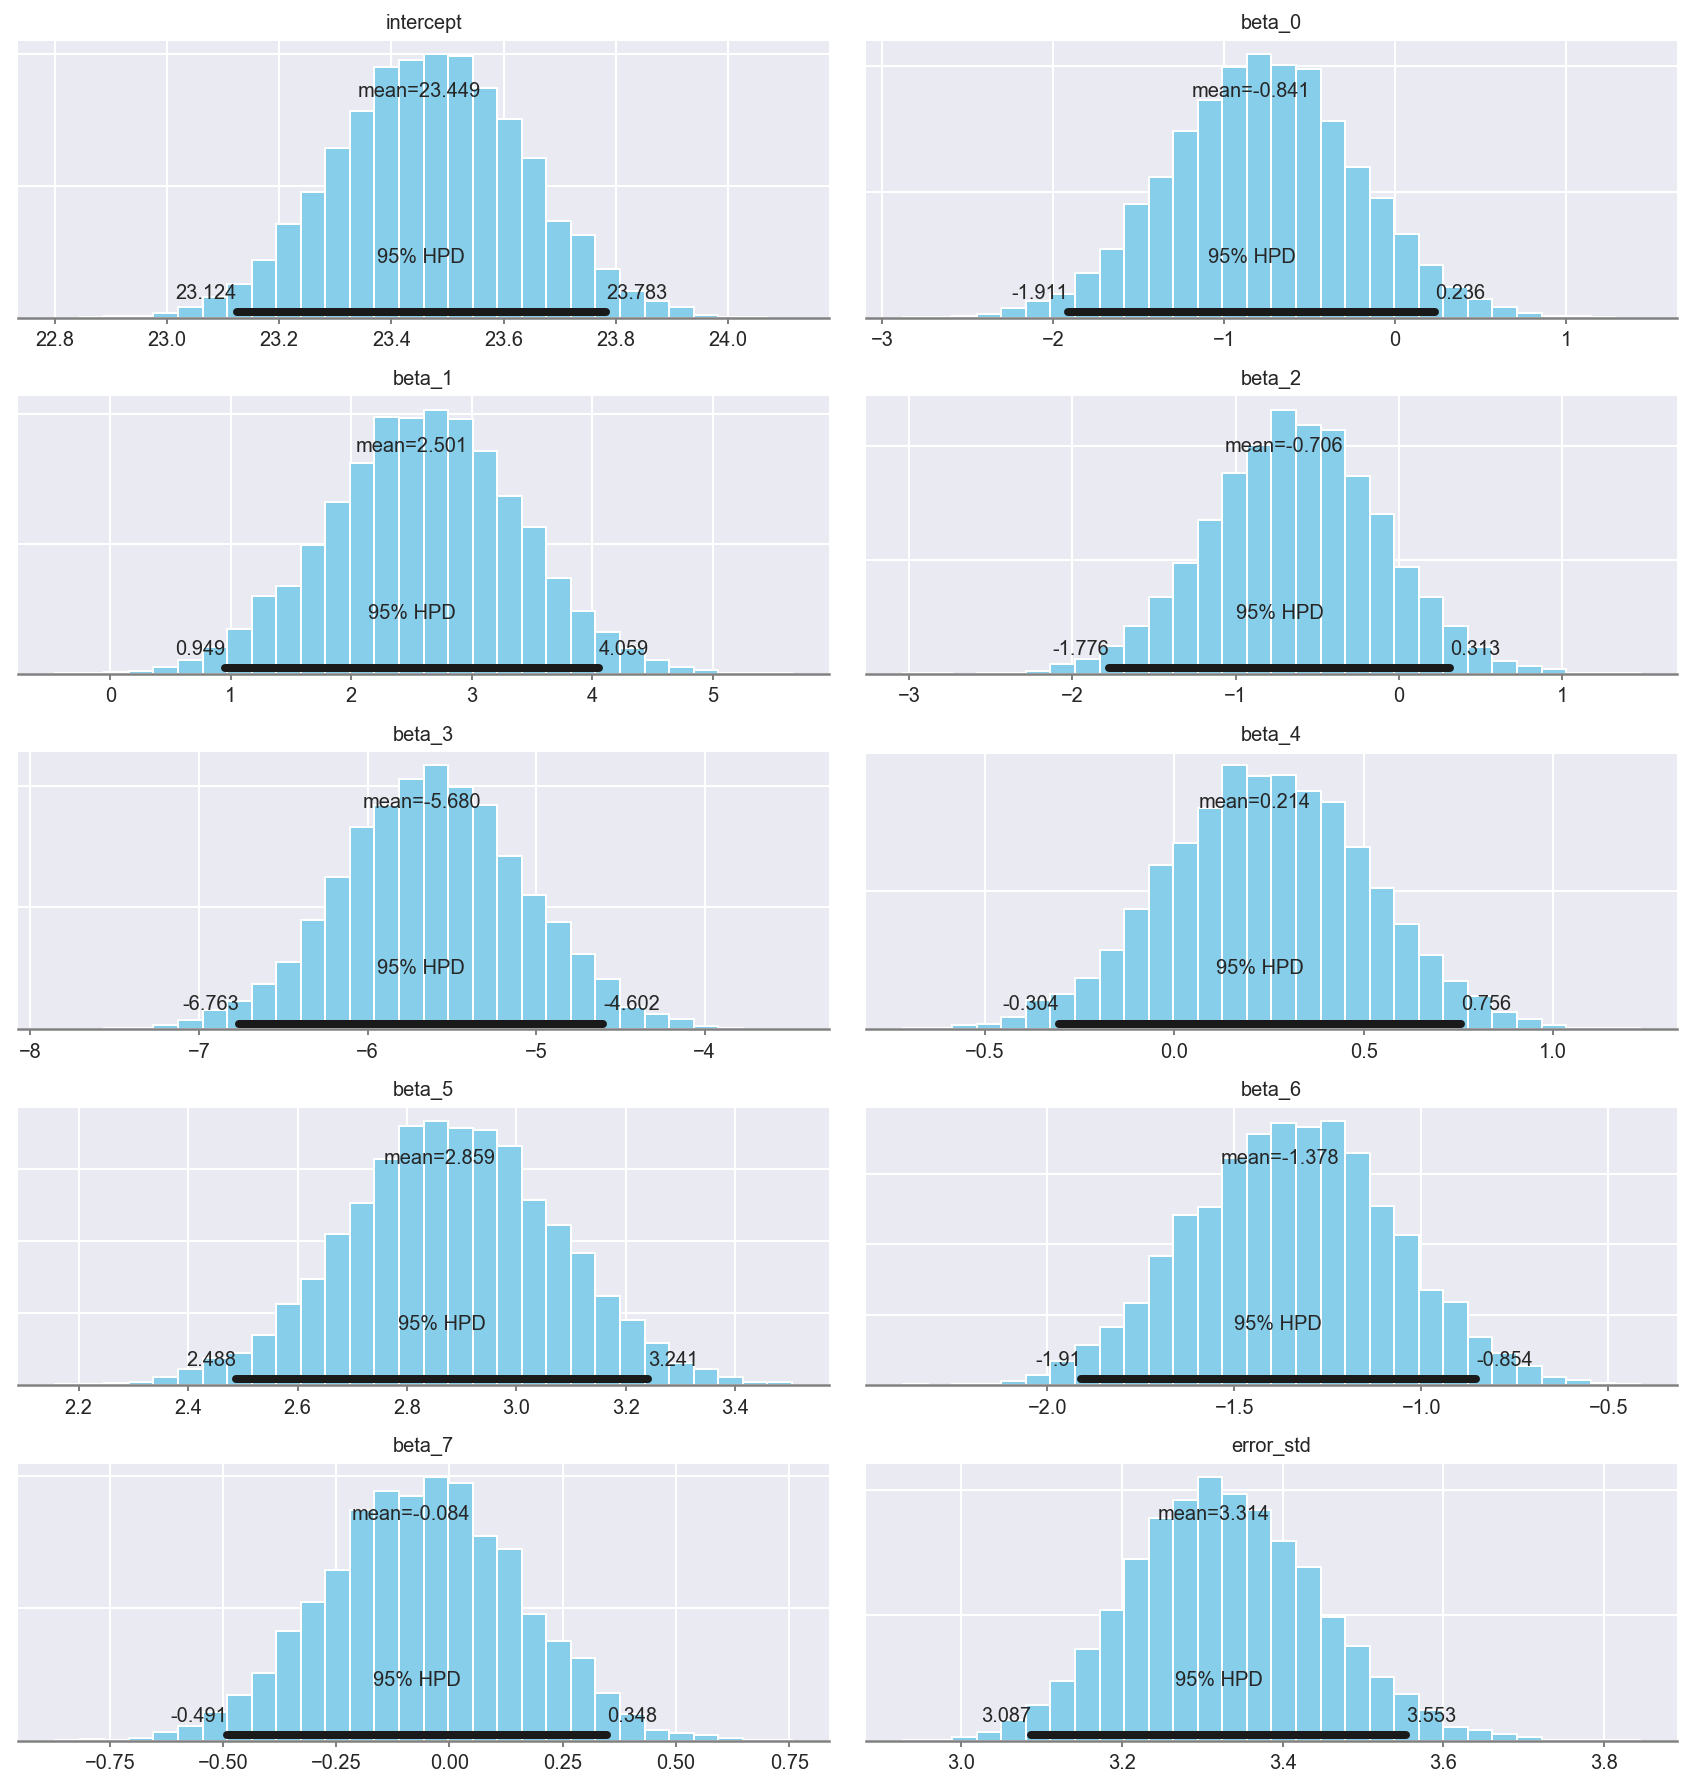

In [38]:
pm.plot_posterior(trace)
plt.show()

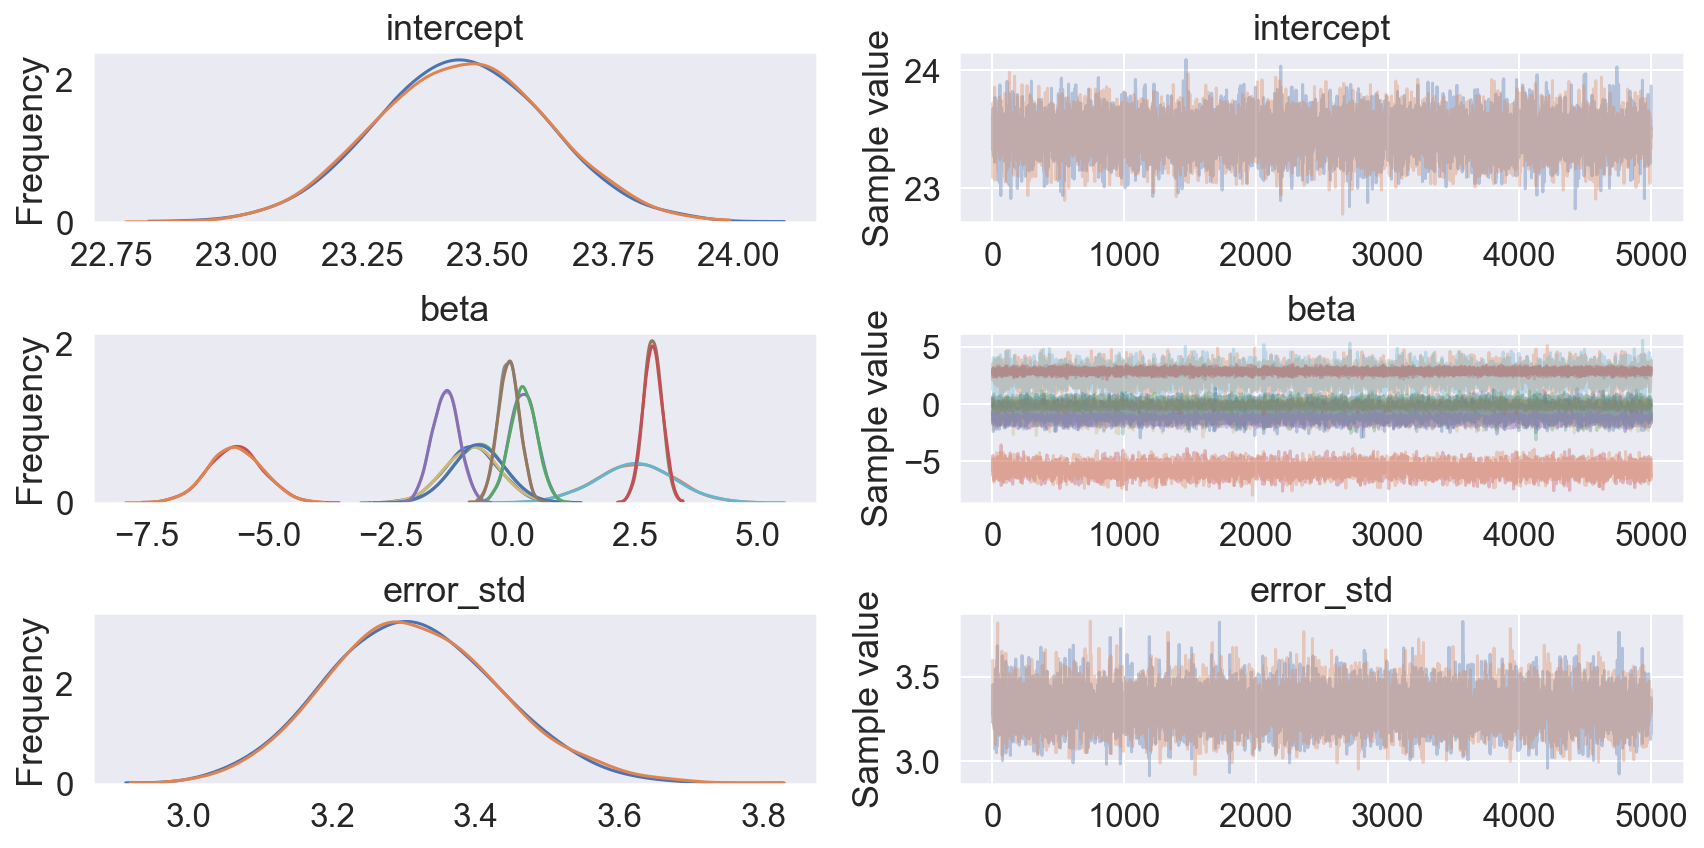

In [39]:
pm.traceplot(trace)
plt.show()

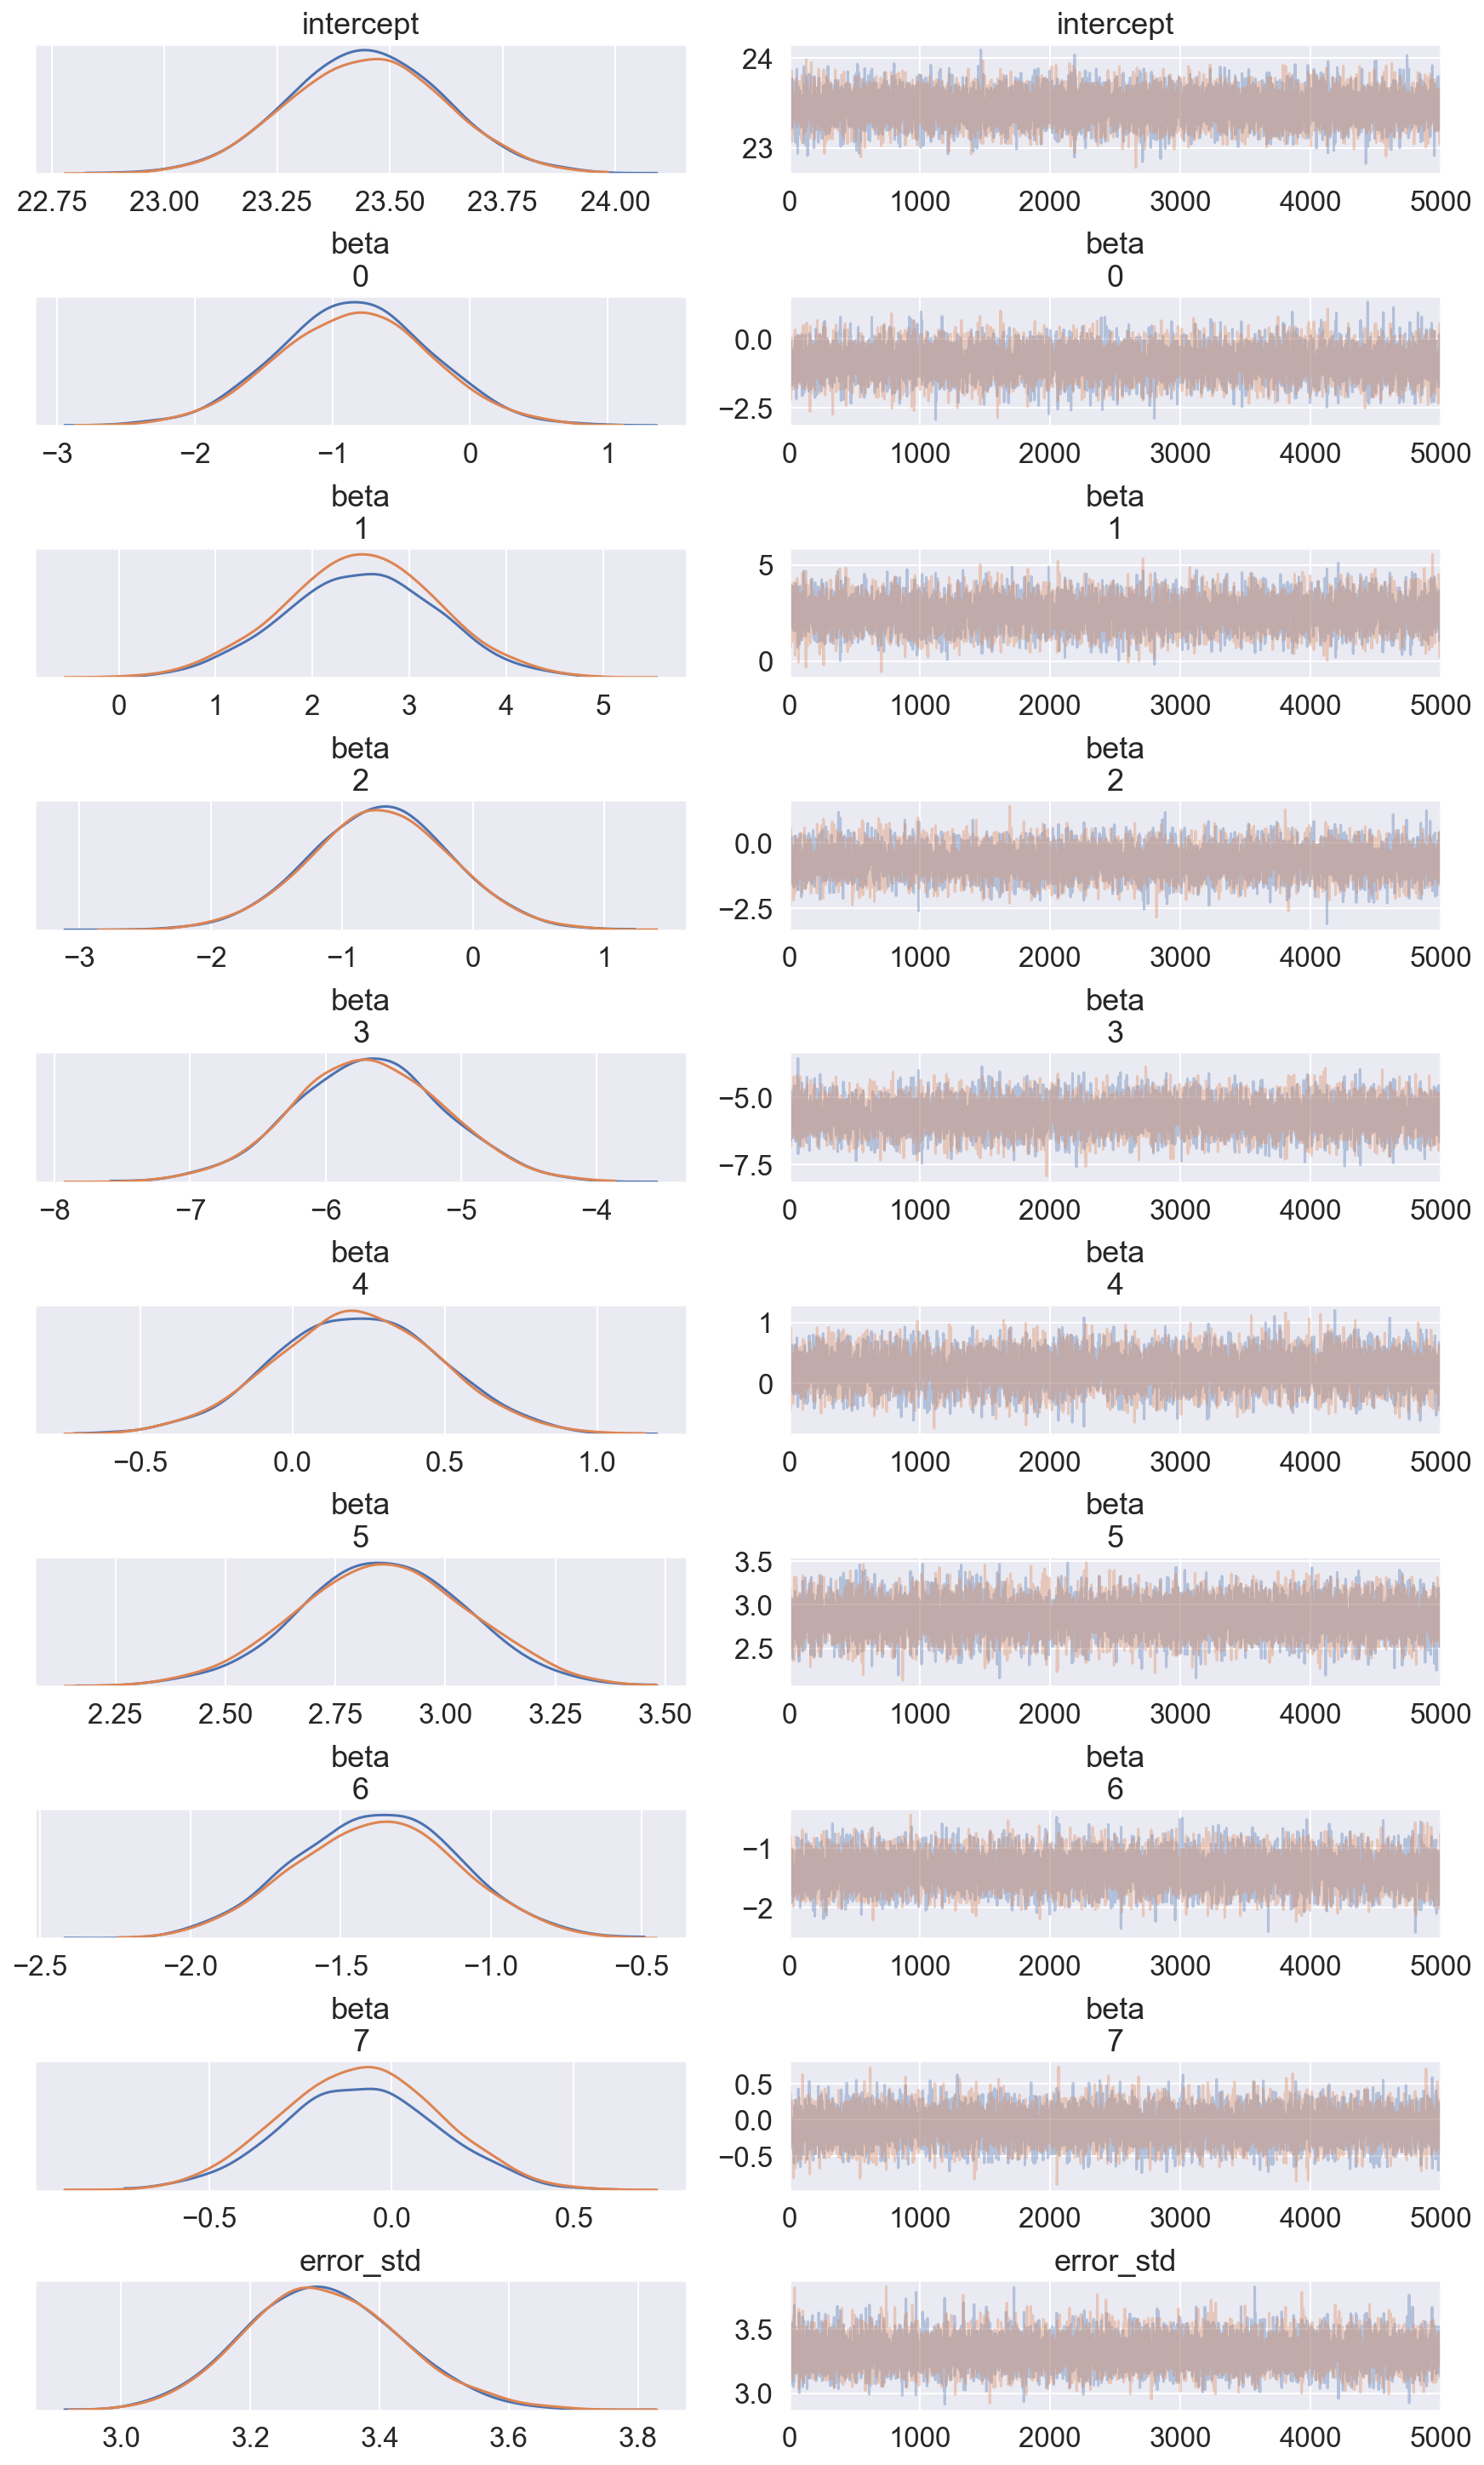

In [40]:
az.plot_trace(trace)
plt.show()

## GLM with formula syntax

We can formulate the same in a neater way using the GLM model which allows to use patsy formulas. It sets some default priors, but for convenience it is also possible to set them in a user-defined way. To make use of the formula language, the target variable has to be in the same dataframe as the predictor variables.

In [41]:
Xs['mpg'] = df.mpg.values

In [42]:
formula = 'mpg~'+('+').join([x for x in Xs.columns if x != 'mpg'])

In [43]:
with pm.Model() as model_glm:
    pm.glm.GLM.from_formula(formula, Xs[predictors+[target]],
                            priors={'Intercept': pm.Normal.dist(mu=y.mean(), sd=prior_std),
                                    'Regressor': pm.Normal.dist(mu=0., sd=prior_std)})
    trace_glm = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, european, american, year, acceleration, weight, horsepower, displacement, cylinders, Intercept]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:39<00:00, 276.86draws/s]


In [44]:
model_glm

### Summary

In [45]:
summary_glm = pm.summary(trace_glm)
summary_glm

mean        sd  mc_error    hpd_2.5   hpd_97.5  \
Intercept     23.445677  0.166289  0.001631  23.123391  23.774228   
cylinders     -0.822870  0.543013  0.005583  -1.875621   0.232740   
displacement   2.466298  0.797005  0.009468   0.927893   4.063309   
horsepower    -0.706805  0.525890  0.006349  -1.745408   0.298106   
weight        -5.662887  0.556647  0.006649  -6.711593  -4.539500   
acceleration   0.209353  0.269096  0.003111  -0.318913   0.739683   
year           2.855927  0.188109  0.002102   2.496073   3.236792   
american      -1.380289  0.269417  0.002967  -1.907863  -0.848286   
european      -0.085518  0.212271  0.002338  -0.493154   0.322550   
sd             3.314782  0.121684  0.001183   3.087628   3.562312   

                    n_eff      Rhat  
Intercept     9006.640523  1.000047  
cylinders     8267.817415  0.999906  
displacement  6828.229578  0.999937  
horsepower    6321.213738  1.000021  
weight        6711.870937  0.999912  
acceleration  6354.907770  1.000008  
year          7746.856553  1.000104  
american      7273.863964  1.000155  
european      7908.455826  0.999928  
sd            9364.446457  1.000097

### Forest plot

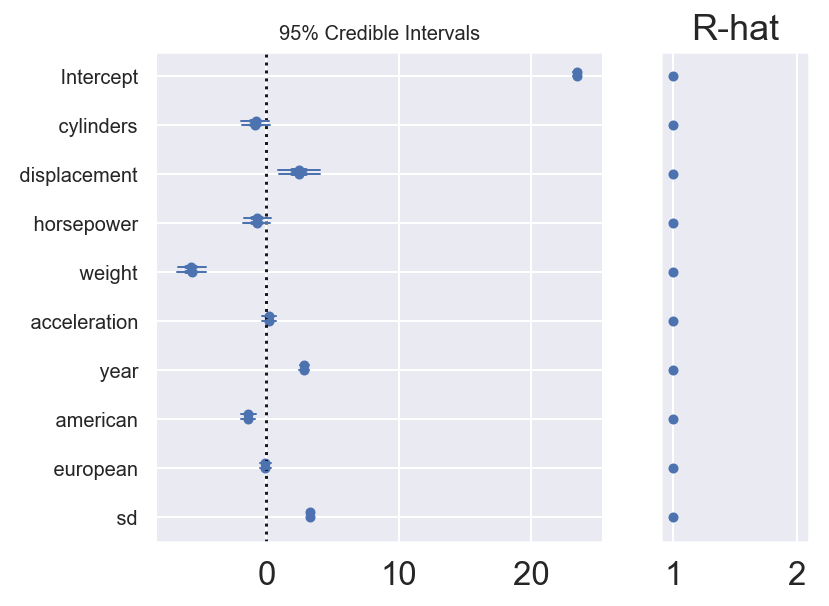

In [46]:
pm.forestplot(trace_glm)
plt.show()

## Regularized regression

By choosing a normal distribution as a prior for the regression coefficients we are already applying some kind of regularization which prevents the coefficients from growing arbitrarily large. We can enhance the effect by diminishing the standard deviation in the prior. Ridge regression can be interpreted as the MAP estimate of this model with uninformed prior.

In [47]:
with pm.Model() as model_reg:
    prior_std = 10
    std = pm.HalfCauchy('error_std', beta=10)
    intercept = pm.Normal('intercept', mu=y.mean(), sd=prior_std)
    beta = pm.Normal('beta', mu=0., sd=prior_std/5, shape=len(predictors))
    y_hat = pm.Normal('y_hat',
                      mu=intercept+pm.math.dot(Xs[predictors], beta),
                      sd=std,
                      observed=y.values)

In [49]:
with model_reg:
    trace_reg = pm.sample(5000, tune=1000, nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept, error_std]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:30<00:00, 395.60draws/s]


### Summary

In [50]:
pm.summary(trace_reg)

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
intercept  23.447028  0.166195  0.001580  23.128956  23.775114  10389.020073   
beta__0    -0.685859  0.512877  0.004908  -1.679172   0.325351  10661.706753   
beta__1     1.862721  0.729128  0.006737   0.390843   3.261708   8593.146335   
beta__2    -0.758663  0.507461  0.005714  -1.753057   0.242792   8073.731784   
beta__3    -5.224668  0.526871  0.005878  -6.210868  -4.119365   8071.837302   
beta__4     0.128967  0.266118  0.002724  -0.388166   0.654558   9021.405755   
beta__5     2.801571  0.191277  0.001805   2.439772   3.196368  12152.694134   
beta__6    -1.337803  0.260694  0.002796  -1.822783  -0.803382   9519.280780   
beta__7    -0.106958  0.212689  0.002180  -0.524411   0.300479  10532.647740   
error_std   3.319707  0.121806  0.001157   3.083792   3.559095  11021.315244   

               Rhat  
intercept  0.999900  
beta__0    0.999924  
beta__1    0.999908  
beta__2    0.999991  
beta__3    0.999901  
beta__4    0.999941  
beta__5    0.999975  
beta__6    0.999958  
beta__7    1.000286  
error_std  1.000055

### Forest plot

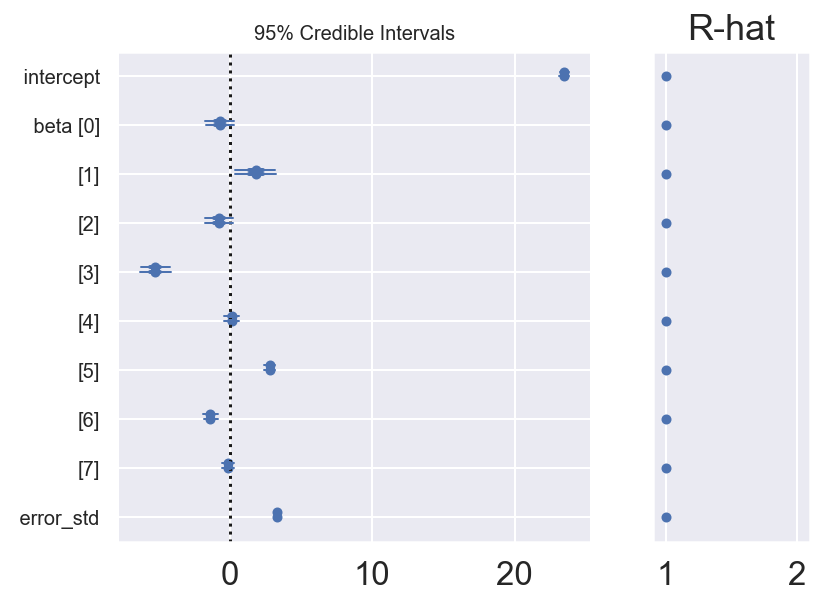

In [51]:
pm.forestplot(trace_reg)
plt.show()

### Lasso regression

We can implement the analog of Lasso regression by choosing a Laplace distribution as a prior for the beta coefficients. Instead of the standard deviation it has a scale parameter $b$, for smaller values the distribution becomes more peaked.

In [52]:
with pm.Model() as model_lasso:
    prior_std = 10
    std = pm.HalfCauchy('error_std', beta=10)
    intercept = pm.Normal('intercept', mu=y.mean(), sd=prior_std)
    beta = pm.Laplace('beta', mu=0., b=prior_std/50, shape=len(predictors))
    y_hat = pm.Normal('y_hat',
                      mu=intercept+pm.math.dot(Xs[predictors], beta),
                      sd=std,
                      observed=y.values)

In [53]:
with model_lasso:
    trace_lasso = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept, error_std]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:18<00:00, 603.17draws/s]


In [54]:
pm.summary(trace_lasso)

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
intercept  23.445639  0.165458  0.001369  23.116971  23.772449  13011.390697   
beta__0    -0.144557  0.236060  0.002763  -0.695893   0.239282   7597.191946   
beta__1    -0.000847  0.239173  0.002665  -0.507317   0.505383   8780.398034   
beta__2    -0.313362  0.296407  0.003879  -0.929154   0.167832   5331.241935   
beta__3    -4.547833  0.386244  0.004868  -5.282783  -3.786809   5934.768102   
beta__4     0.065961  0.160068  0.001736  -0.255636   0.395697   8444.944112   
beta__5     2.650998  0.184207  0.001649   2.281787   3.005066  11430.954172   
beta__6    -0.916334  0.233920  0.001890  -1.398341  -0.472109  10064.744539   
beta__7    -0.014803  0.144777  0.001376  -0.339849   0.255384   9141.027142   
error_std   3.353901  0.117832  0.000972   3.127882   3.588857  11507.037177   

               Rhat  
intercept  0.999900  
beta__0    0.999909  
beta__1    0.999946  
beta__2    0.999943  
beta__3    0.999947  
beta__4    0.999902  
beta__5    0.999943  
beta__6    0.999974  
beta__7    0.999922  
error_std  0.999936

In [55]:
preds = pm.sample_posterior_predictive(trace_reg, model=model_reg)
pm.r2_score(y.values, preds['y_hat']).r2_mean

100%|██████████| 10000/10000 [00:06<00:00, 1476.05it/s]


0.73

### Forest plot

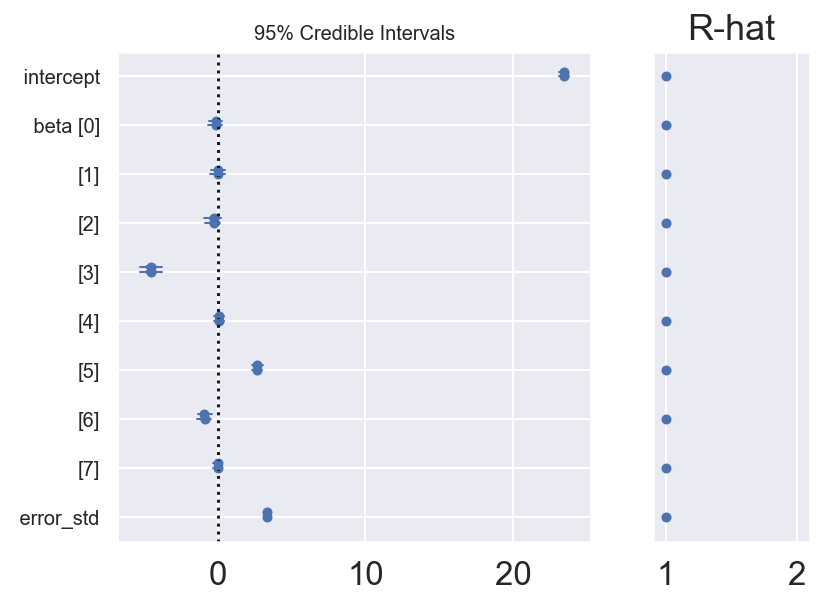

In [56]:
pm.forestplot(trace_lasso)
plt.show()

### Trace plot

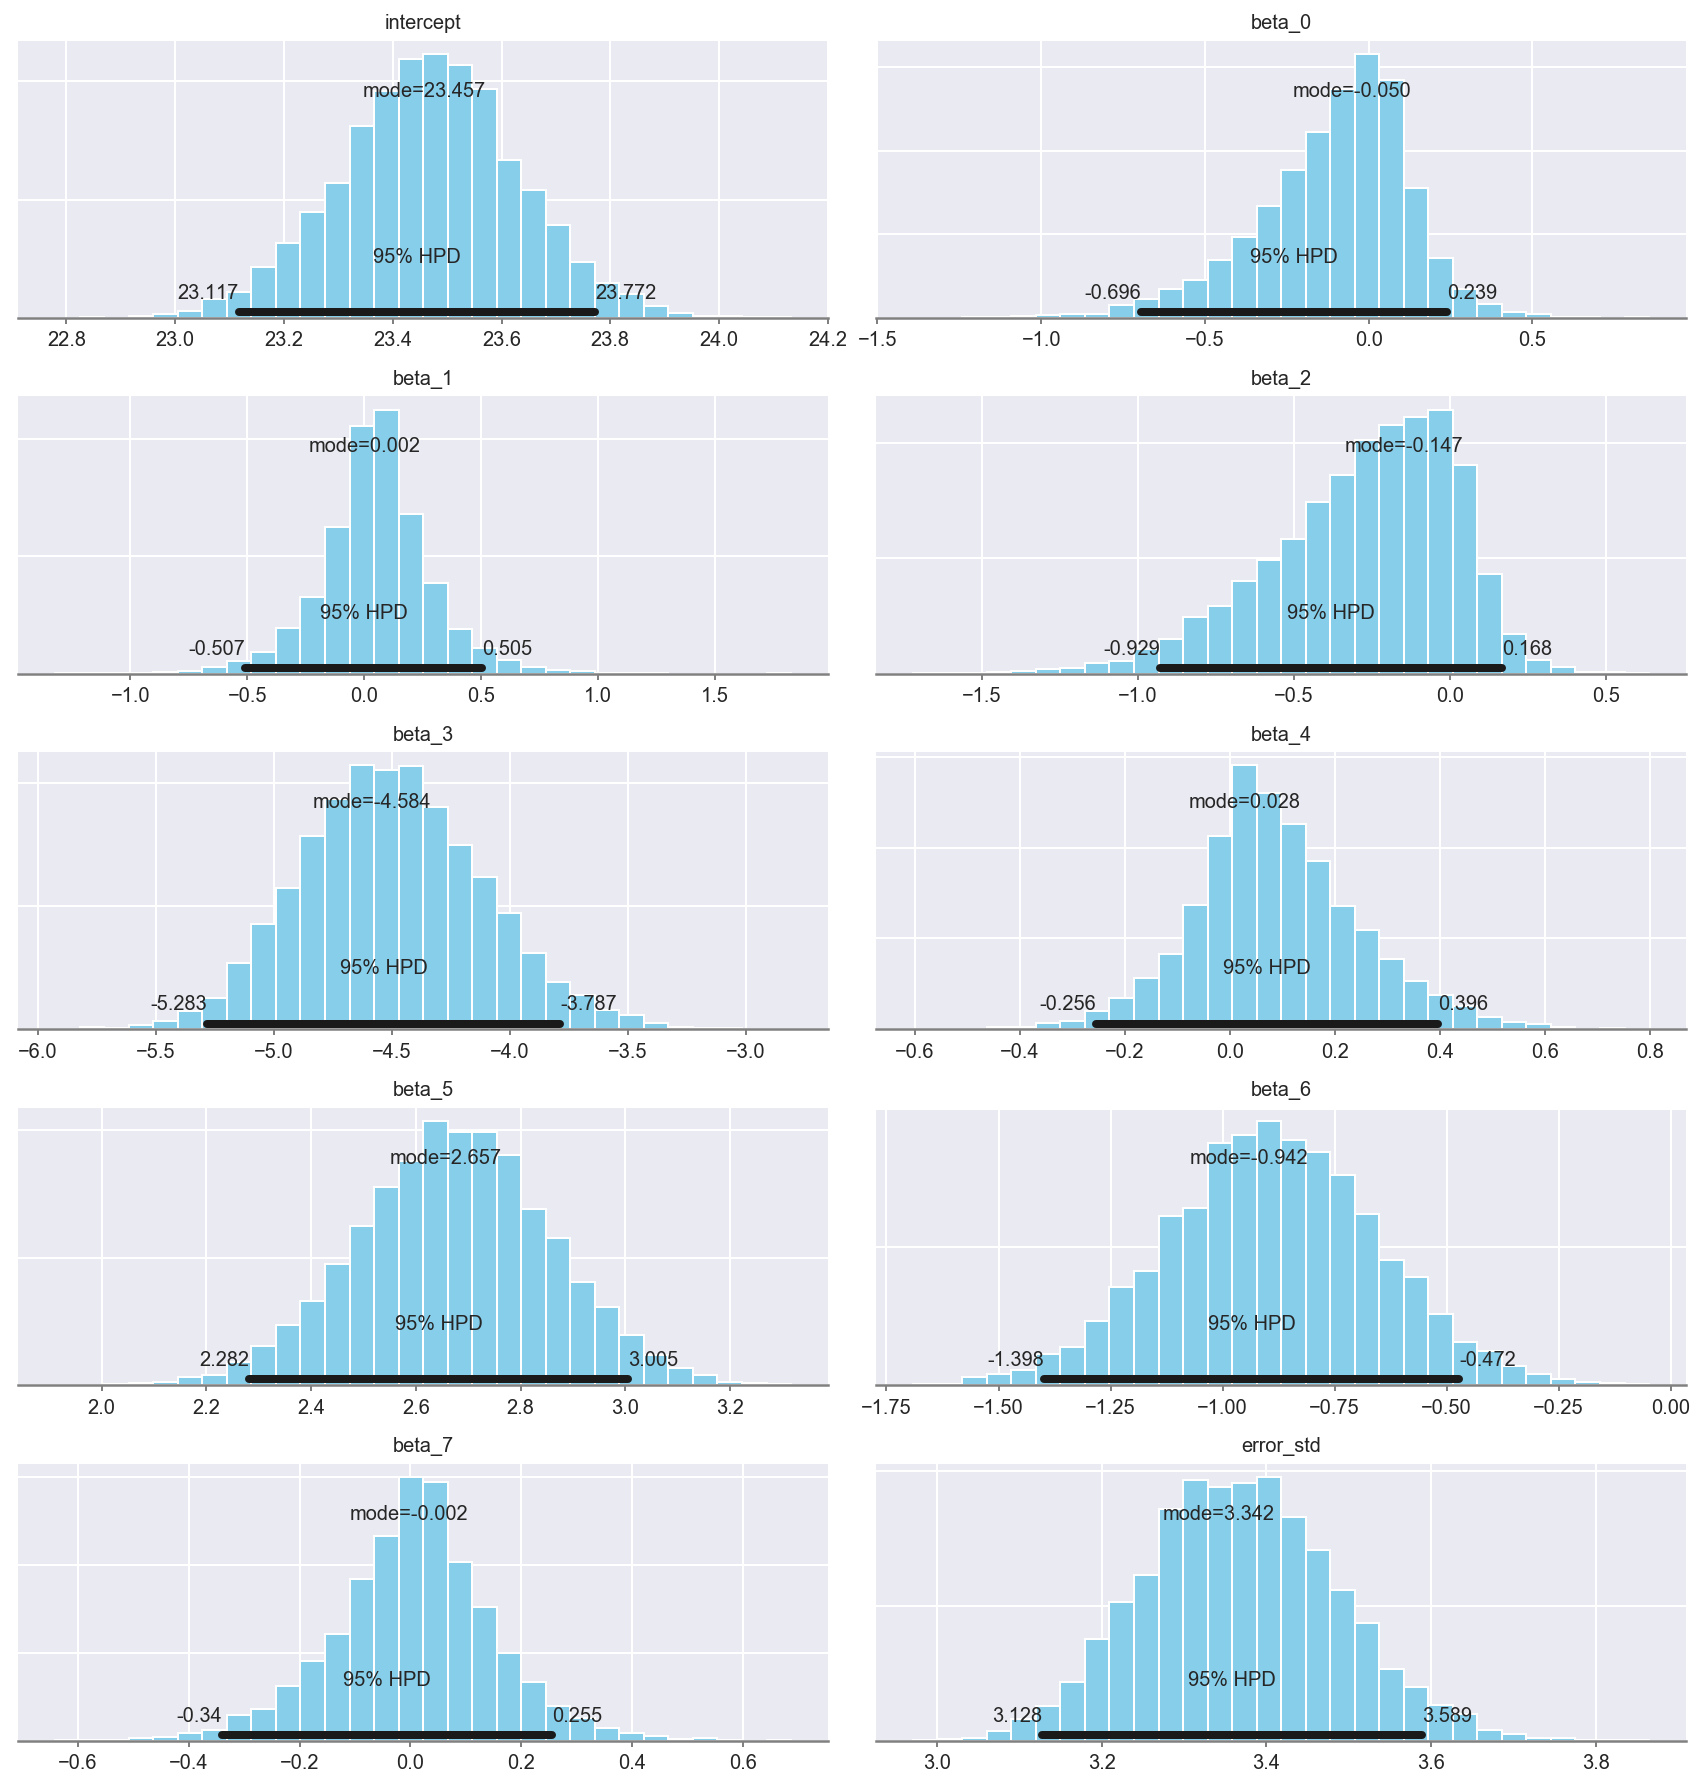

In [73]:
pm.plot_posterior(trace_lasso, point_estimate='mode')
plt.show()

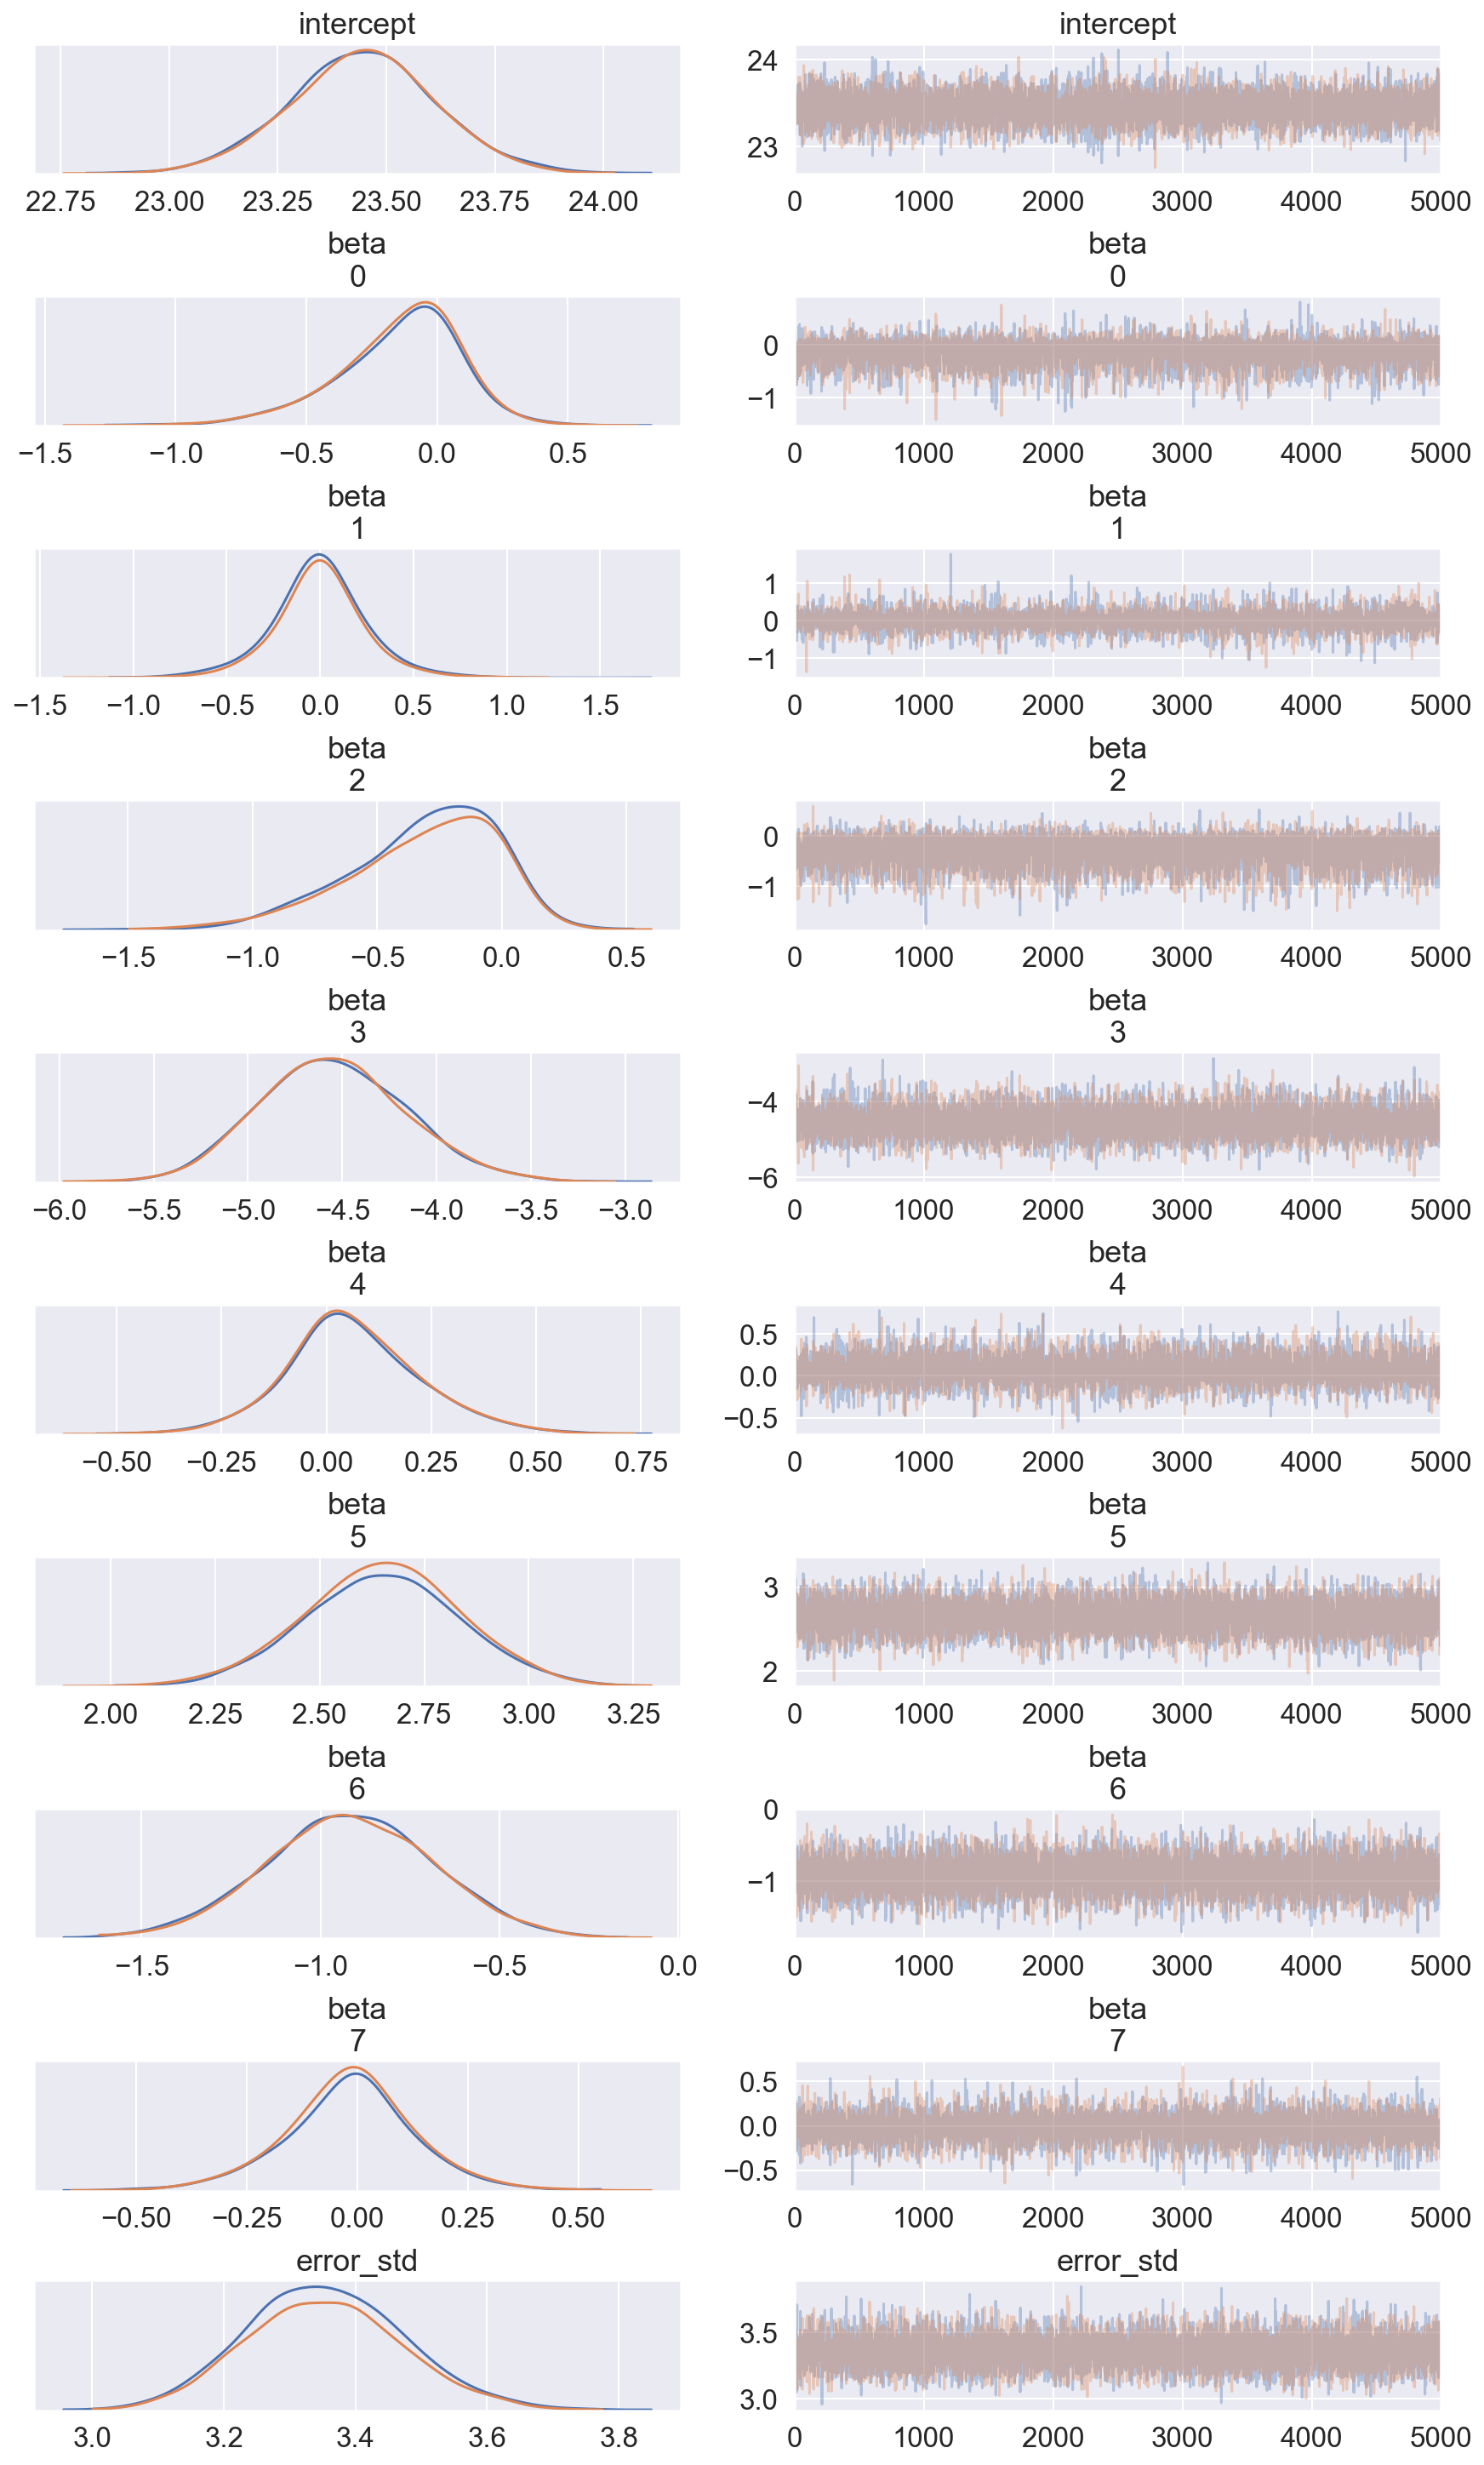

In [57]:
az.plot_trace(trace_lasso)
plt.show()

In [58]:
preds = pm.sample_posterior_predictive(trace_lasso, model=model_lasso)
pm.r2_score(y.values, preds['y_hat']).r2_mean

100%|██████████| 10000/10000 [00:08<00:00, 1226.08it/s]


0.72

## Robust regression

We can make our estimates more robust by choosing a t-distribution for the likelihood function and adding the appropriate priors.

In [59]:
with pm.Model() as model_robust:
    prior_std = 10
    std = pm.HalfCauchy('error_std', beta=10)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)

    intercept = pm.Normal('intercept', mu=y.mean(), sd=prior_std)
    beta = pm.Normal('beta', mu=0., sd=prior_std, shape=len(predictors))
    y_hat = pm.StudentT('y_hat',
                        nu=nu,
                        mu=intercept+pm.math.dot(Xs[predictors], beta),
                        sd=std,
                        observed=y.values)

In [60]:
with model_robust:
    trace_robust = pm.sample(draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, intercept, nu_minus1, error_std]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:48<00:00, 226.38draws/s]


### Summary

In [61]:
pm.summary(trace_robust)

mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
intercept  23.308721  0.154645  0.001647  23.017434  23.618572  9383.390926   
beta__0    -0.958906  0.513870  0.005326  -1.922998   0.062807  7612.709112   
beta__1     1.545635  0.827507  0.009965  -0.051875   3.162513  5531.565264   
beta__2    -0.549082  0.487165  0.006026  -1.497883   0.407521  6355.960148   
beta__3    -4.929933  0.583793  0.007341  -6.051893  -3.775851  5370.430236   
beta__4    -0.159962  0.280432  0.003651  -0.697387   0.396912  6436.759779   
beta__5     2.558889  0.188700  0.002036   2.202201   2.936024  7215.404198   
beta__6    -1.393060  0.252153  0.002808  -1.881384  -0.898479  7298.995045   
beta__7    -0.407132  0.228512  0.002843  -0.863426   0.031802  6236.742393   
error_std   2.635746  0.193896  0.002803   2.266263   3.023928  5714.928763   
nu_minus1   4.769874  2.677634  0.039535   1.538277   9.014833  4326.303303   
nu          5.769874  2.677634  0.039535   2.538277  10.014833  4326.303303   

               Rhat  
intercept  0.999903  
beta__0    0.999926  
beta__1    0.999906  
beta__2    1.000402  
beta__3    0.999984  
beta__4    0.999903  
beta__5    1.000157  
beta__6    0.999916  
beta__7    1.000064  
error_std  1.000282  
nu_minus1  1.000369  
nu         1.000369

Compare the highest posterior density intervals for normal and robust regression:

In [62]:
pm.summary(trace)['hpd_97.5']-pm.summary(trace)['hpd_2.5']

intercept    0.659039
beta__0      2.146581
beta__1      3.109154
beta__2      2.088835
beta__3      2.160822
beta__4      1.060233
beta__5      0.753656
beta__6      1.056595
beta__7      0.839507
error_std    0.466115
dtype: float64

In [63]:
pm.summary(trace_robust)['hpd_97.5']-pm.summary(trace_robust)['hpd_2.5']

intercept    0.601138
beta__0      1.985805
beta__1      3.214388
beta__2      1.905404
beta__3      2.276043
beta__4      1.094299
beta__5      0.733823
beta__6      0.982906
beta__7      0.895228
error_std    0.757665
nu_minus1    7.476556
nu           7.476556
dtype: float64

In [64]:
preds = pm.sample_posterior_predictive(trace_robust, model=model_robust)
pm.r2_score(y.values, preds['y_hat']).r2_mean

100%|██████████| 10000/10000 [00:07<00:00, 1304.94it/s]


0.72

### Forest plot

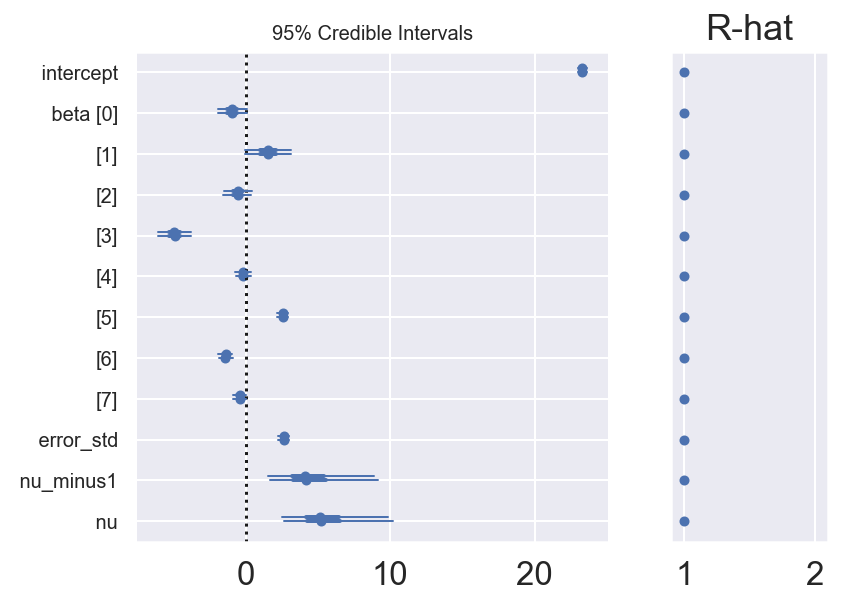

In [65]:
pm.forestplot(trace_robust)
plt.show()

### Trace plot

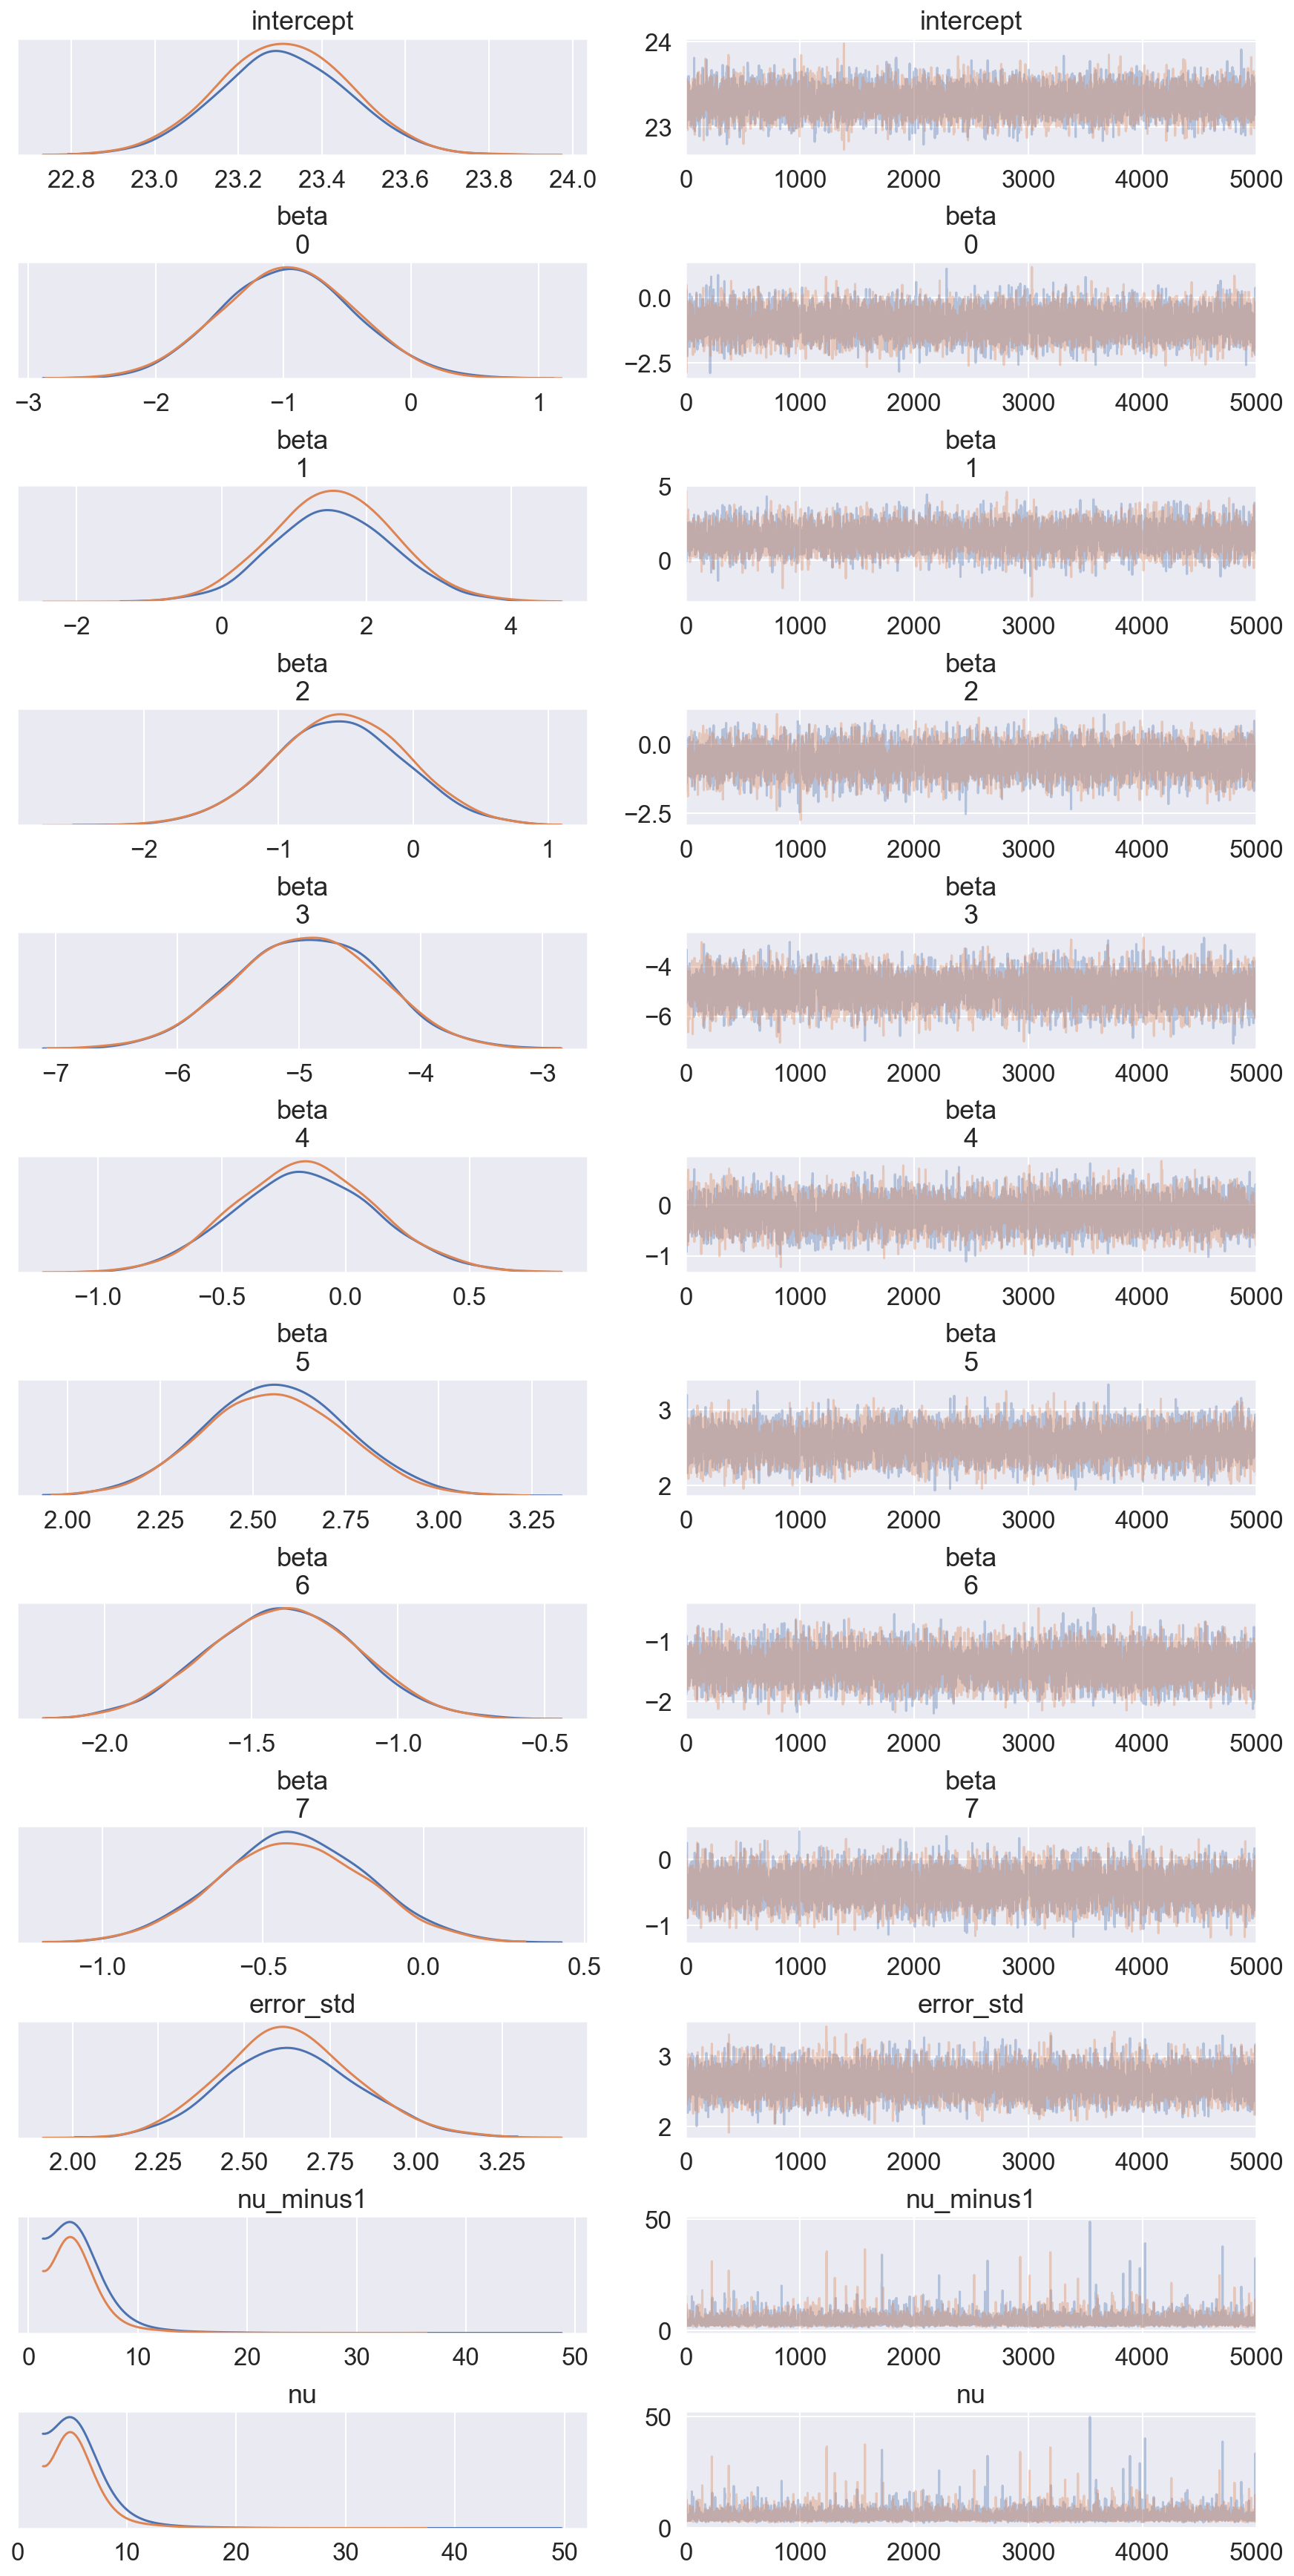

In [66]:
az.plot_trace(trace_robust)
plt.show()

In [67]:
ppc = pm.sample_posterior_predictive(trace_robust, samples=300, model=model)
az_data = az.from_pymc3(trace=trace_robust, posterior_predictive=ppc)

100%|██████████| 300/300 [00:00<00:00, 1398.63it/s]


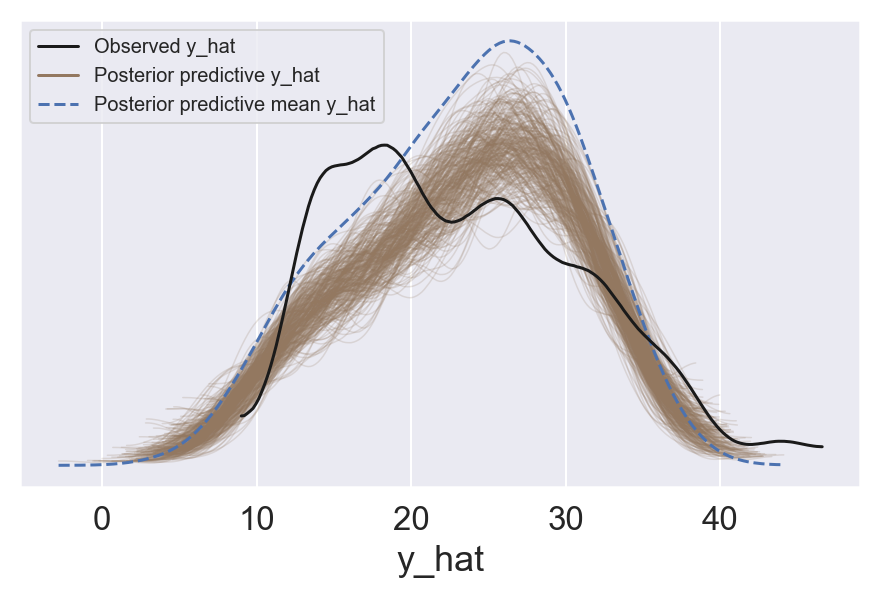

In [68]:
ax = az.plot_ppc(az_data, kind='density')
ax[0].legend(fontsize=10)
plt.show()

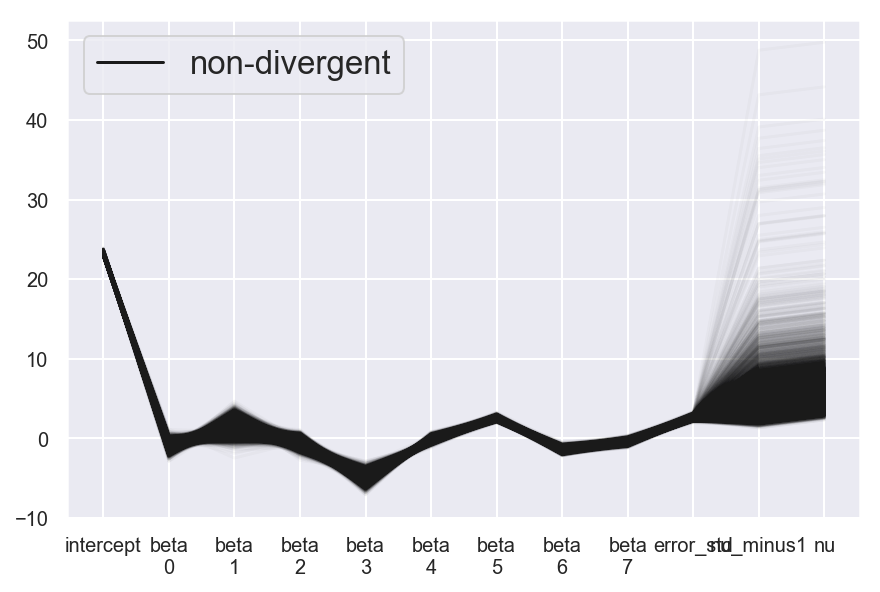

In [69]:
az.plot_parallel(trace_robust)
plt.show()

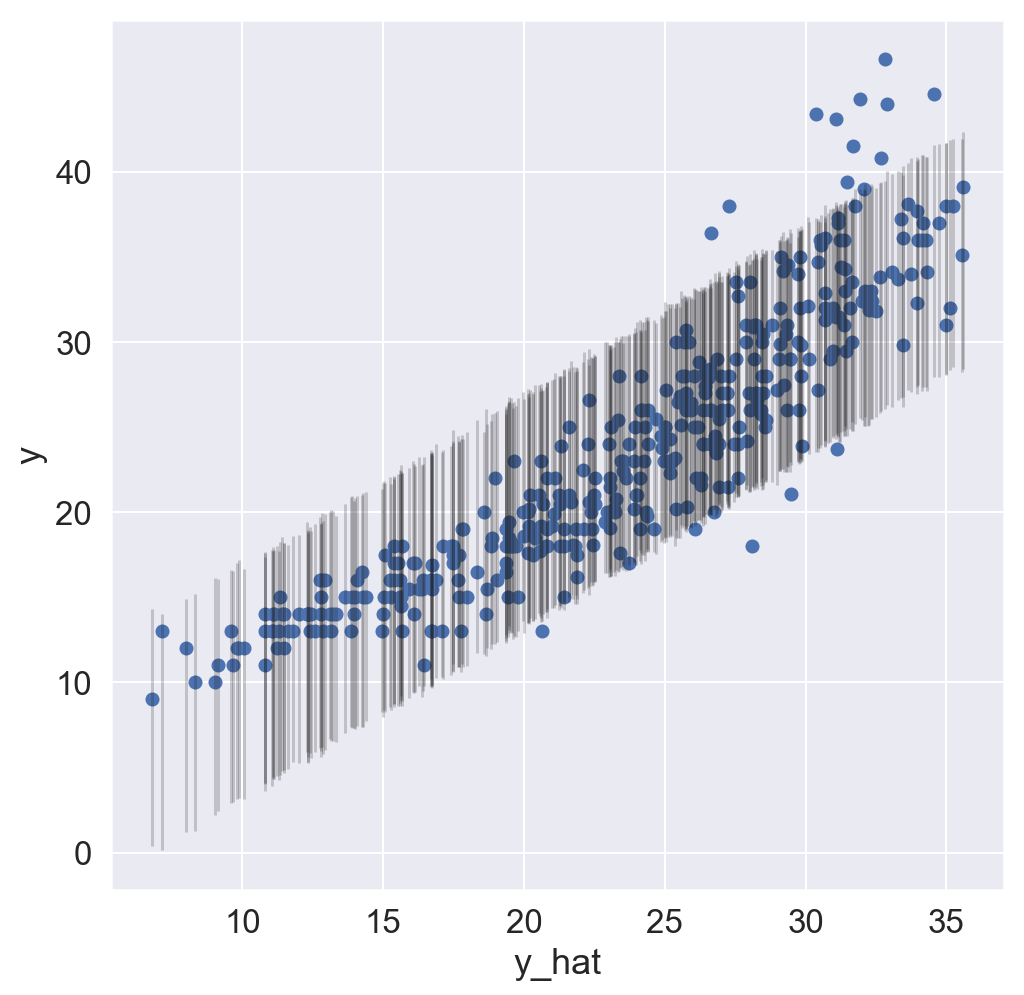

In [70]:
predictions = preds['y_hat'].mean(axis=0)
hpds = np.apply_along_axis(pm.hpd, 0, preds['y_hat']).T

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(predictions, y)
for i in range(len(y)):
    ax.vlines(predictions[i], hpds[i, 0], hpds[i, 1], alpha=0.2)
ax.set_xlabel('y_hat')
ax.set_ylabel('y')
plt.show()